In [ ]:
# default_exp mining.unsupervised.traceability.approach

# Neural Unsupervised Approaches for SE Traceability [approach]

> This module is dedicated to evaluate word2vec/doc2vec or any neural unsupervised approaches on traceability datasets. Consider to Copy the entire notebook for a new and separeted empirical evaluation. 
>
> Author: @danaderp April 2020

In [ ]:
#TODO
# http://www.ashukumar27.io/similarity_functions/
# https://www.kdnuggets.com/2017/08/comparing-distance-measurements-python-scipy.html
# https://towardsdatascience.com/importance-of-distance-metrics-in-machine-learning-modelling-e51395ffe60d
# https://www.kdnuggets.com/2019/01/comparison-text-distance-metrics.html

In [ ]:
#hide
#! pip install seaborn
#! pip install sklearn
#!pip install pyprg
!pip install pyemd

     |████████████████████████████████| 91 kB 2.3 MB/s eta 0:00:011
  Created wheel for pyemd: filename=pyemd-0.5.1-cp36-cp36m-linux_x86_64.whl size=377293 sha256=99b2447d772acbfeaae229366bf8ed7b7f7c81e61390d86faebca2e01b0af756
  Stored in directory: /root/.cache/pip/wheels/f9/f0/23/aefbdde40e915c67830ebecb55be2344a8b6e95fe3ce3ccf96
Successfully built pyemd


In [ ]:
# export
# Imports
import numpy as np
import gensim
import pandas as pd
from itertools import product 
from random import sample 
import functools 
import os

In [ ]:
from datetime import datetime
import seaborn as sns

In [ ]:
#export
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
from prg import prg
from pandas.plotting import scatter_matrix
from pandas.plotting import lag_plot
import math as m
import random as r
import collections
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
from gensim.models import WordEmbeddingSimilarityIndex
from gensim.similarities import SparseTermSimilarityMatrix
from gensim import corpora

In [ ]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cosine.html
from scipy.spatial import distance
from scipy.stats import pearsonr

In [ ]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# Artifacts Similarity with BasicSequenceVectorization

We test diferent similarities based on [blog](https://www.kdnuggets.com/2017/08/comparing-distance-measurements-python-scipy.html) and [blog2](https://www.kdnuggets.com/2019/01/comparison-text-distance-metrics.html)

In [ ]:
from enum import Enum, unique, auto

In [ ]:
@unique
class VectorizationType(Enum):
    word2vec = auto()
    doc2vec = auto()
    vsm2vec = auto()

In [ ]:
@unique
class LinkType(Enum):
    req2tc = auto()
    req2src = auto()

In [ ]:
@unique
class DistanceMetric(Enum):
    WMD = auto()
    COS = auto()
    SCM = auto()
    EUC = auto()
    MAN = auto()

In [ ]:
@unique
class SimilarityMetric(Enum):
    WMD_sim = auto()
    COS_sim = auto()
    SCM_sim = auto()
    EUC_sim = auto()
    MAN_sim = auto()
    Pearson = auto()

In [ ]:
#"path_to_trained_model": 'test_data/models/word2vec_libest.model',
path_to_trained_model = 'test_data/models/wv/conv/[word2vec-Py-Java-Wiki-SK-500-20E[0]-1592979270.711115].model',
#"path_to_trained_model": 'test_data/models/wv/conv/[word2vec-Py-Java-Wiki-SK-500-20E[12]-1593160455.729312].model',
#"path_to_trained_model": 'test_data/models/wv/bpe32k/[word2vec-Py-Java-SK-500-20E-32k-1593748814.350487].model',
#path_to_trained_model = 'test_data/models/wv/bpe128k/[word2vec-Java-Py-SK-500-20E-128k-1594873397.267055].model'
#path_to_trained_model = 'test_data/models/wv/bpe128k/[word2vec-Java-Py-Wiki-SK-500-20E-128k[15]-1595189771.501188].model'

In [ ]:
def default_params():
    return {
        "vectorizationType": VectorizationType.word2vec,
        "linkType": LinkType.req2tc,
        "system": 'libest',
        "path_to_trained_model": path_to_trained_model,
        "source_path": '/tf/main/benchmarking/traceability/testbeds/nltk/[libest-pre-req].csv',
        "target_path": '/tf/main/benchmarking/traceability/testbeds/nltk/[libest-pre-tc].csv',
        "system_path": '/tf/main/benchmarking/traceability/testbeds/nltk/[libest-pre-all].csv',
        "saving_path": 'test_data/',
        "names": ['Source','Target','Linked?']
    }

### Defining BasicSequenceVectorization

In [ ]:
parameters = default_params()
parameters

{'vectorizationType': <VectorizationType.word2vec: 1>,
 'linkType': <LinkType.req2tc: 1>,
 'system': 'libest',
 'path_to_trained_model': ('test_data/models/wv/conv/[word2vec-Py-Java-Wiki-SK-500-20E[0]-1592979270.711115].model',),
 'source_path': '/tf/main/benchmarking/traceability/testbeds/nltk/[libest-pre-req].csv',
 'target_path': '/tf/main/benchmarking/traceability/testbeds/nltk/[libest-pre-tc].csv',
 'system_path': '/tf/main/benchmarking/traceability/testbeds/nltk/[libest-pre-all].csv',
 'saving_path': 'test_data/',
 'names': ['Source', 'Target', 'Linked?']}

In [ ]:
#tst
print(list(VectorizationType), list(DistanceMetric), list(SimilarityMetric), list(LinkType))

[<VectorizationType.word2vec: 1>, <VectorizationType.doc2vec: 2>, <VectorizationType.vsm2vec: 3>] [<DistanceMetric.WMD: 1>, <DistanceMetric.COS: 2>, <DistanceMetric.SCM: 3>, <DistanceMetric.EUC: 4>, <DistanceMetric.MAN: 5>] [<SimilarityMetric.WMD_sim: 1>, <SimilarityMetric.COS_sim: 2>, <SimilarityMetric.SCM_sim: 3>, <SimilarityMetric.EUC_sim: 4>, <SimilarityMetric.MAN_sim: 5>, <SimilarityMetric.Pearson: 6>] [<LinkType.req2tc: 1>, <LinkType.req2src: 2>]


In [ ]:
#export
class BasicSequenceVectorization():
    '''Implementation of the class sequence-vanilla-vectorization other classes can inheritance this one'''
    def __init__(self, params):
                
        self.df_source = pd.read_csv(params['source_path'], names=['ids', 'text'], header=None, sep=' ')
        self.df_target = pd.read_csv(params['target_path'], names=['ids', 'text'], header=None, sep=' ')
        self.df_all_system = pd.read_csv(params['system_path'], names=['ids', 'text'], 
                                         header=0, index_col=0, sep=',')
        self.params = params
        self.df_nonground_link = None
        self.df_ground_link = None
        
        self.documents = [doc.split() for doc in self.df_all_system['text'].values] #Preparing Corpus
        self.dictionary = corpora.Dictionary( self.documents ) #Preparing Dictionary
        
        
        #This can be extended for future metrics <---------------------
        self.dict_labels = {
            DistanceMetric.COS:[DistanceMetric.COS, SimilarityMetric.COS_sim],
            SimilarityMetric.Pearson:[SimilarityMetric.Pearson],
            DistanceMetric.EUC:[DistanceMetric.EUC, SimilarityMetric.EUC_sim],
            DistanceMetric.WMD:[DistanceMetric.WMD, SimilarityMetric.WMD_sim],
            DistanceMetric.SCM:[DistanceMetric.SCM, SimilarityMetric.SCM_sim],
            DistanceMetric.MAN:[DistanceMetric.MAN, SimilarityMetric.MAN_sim]
        }

        
    def ground_truth_processing(self, path_to_ground_truth):
        'Optional class when corpus has ground truth'
        ground_truth = open(path_to_ground_truth,'r')
        #Organizing The Ground Truth under the given format
        ground_links = [ [(line.strip().split()[0], elem) for elem in line.strip().split()[1:]] for line in ground_truth]
        ground_links = functools.reduce(lambda a,b : a+b,ground_links) #reducing into one list
        assert len(ground_links) ==  len(set(ground_links)) #To Verify Redundancies in the file
        return ground_links
    
    def samplingLinks(self, sampling = False, samples = 10):
        source = [os.path.basename(elem) for elem in self.df_source['ids'].values ] 
        target = [os.path.basename(elem) for elem in self.df_target['ids'].values ]

        if sampling:
            links = sample( list( product( source , target ) ), samples)
        else:
            links = list( product( source , target ))

        return links
    
    def cos_scipy(self, vector_v, vector_w):
        cos =  distance.cosine( vector_v, vector_w )
        return [cos, 1.-cos]
    
    def euclidean_scipy(self, vector_v, vector_w):
        dst = distance.euclidean(vector_v,vector_w)
        return [dst, 1./(1.+dst)] #Computing the inverse for similarity
    
    def manhattan_scipy(self, vector_v, vector_w):
        dst = distance.cityblock(vector_v,vector_w)
        n = len(vector_v)
        return [dst, 1./(1.+dst)] #Computing the inverse for similarity
    
    def pearson_abs_scipy(self, vector_v, vector_w):
        '''We are not sure that pearson correlation works well on doc2vec inference vectors'''
        #vector_v =  np.asarray(vector_v, dtype=np.float32)
        #vector_w =  np.asarray(vector_w, dtype=np.float32)
        logging.info("pearson_abs_scipy" + str(vector_v) + "__" + str(vector_w))
        corr, _ = pearsonr(vector_v, vector_w)
        return [abs(corr)] #Absolute value of the correlation
    

    def computeDistanceMetric(self, links, metric_list):
        '''Metric List Iteration''' 
        
        metric_labels = [ self.dict_labels[metric] for metric in metric_list] #tracking of the labels
        distSim = [[link[0], link[1], self.distance( metric_list, link )] for link in links] #Return the link with metrics
        distSim = [[elem[0], elem[1]] + elem[2] for elem in distSim] #Return the link with metrics
        
        return distSim, functools.reduce(lambda a,b : a+b, metric_labels)
    
    def ComputeDistanceArtifacts(self, metric_list, sampling = False , samples = 10):
        '''Acticates Distance and Similarity Computations
        @metric_list if [] then Computes All metrics
        @sampling is False by the default
        @samples is the number of samples (or links) to be generated'''
        links_ = self.samplingLinks( sampling, samples )
        
        docs, metric_labels = self.computeDistanceMetric( metric_list=metric_list, links=links_) #checkpoints
        self.df_nonground_link = pd.DataFrame(docs, columns =[self.params['names'][0], self.params['names'][1]]+ metric_labels) #Transforming into a Pandas
        logging.info("Non-groundtruth links computed")
        pass 
    
    
    def SaveLinks(self, grtruth=False, sep=' ', mode='a'):
        timestamp = datetime.timestamp(datetime.now())
        path_to_link = self.params['saving_path'] + '['+ self.params['system'] + '-' + str(self.params['vectorizationType']) + '-' + str(self.params['linkType']) + '-' + str(grtruth) + '-{}].csv'.format(timestamp)
        
        if grtruth:
            self.df_ground_link.to_csv(path_to_link, header=True, index=True, sep=sep, mode=mode)
        else:
            self.df_nonground_link.to_csv(path_to_link, header=True, index=True, sep=sep, mode=mode)
        
        logging.info('Saving in...' + path_to_link)
        pass
    
    def findDistInDF(self, g_tuple):
        dist = self.df_ground_link[self.df_ground_link[self.params['names'][0]].str.contains( g_tuple[0][:g_tuple[0].find('.')] + '-' ) 
                     & self.df_ground_link[self.params['names'][1]].str.contains(g_tuple[1][:g_tuple[1].find('.')]) ]        
        return dist.index.values
        
    def MatchWithGroundTruth(self, path_to_ground_truth ):
        self.df_ground_link = self.df_nonground_link.copy()
        
        matchGT = [ self.findDistInDF( g ) for g in self.ground_truth_processing(path_to_ground_truth)]
        matchGT = functools.reduce(lambda a,b : np.concatenate([a,b]), matchGT)
        
        self.df_ground_link[self.params['names'][2]] = 0
        new_column = pd.Series(np.full([len(matchGT)], 1 ), name=self.params['names'][2], index = matchGT)
        self.df_ground_link.update(new_column)
        logging.info("Groundtruth links computed")
        
        pass

In [ ]:
general2vec =  BasicSequenceVectorization(params = parameters)

2020-07-21 17:38:32,099 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:38:32,154 : INFO : built Dictionary(6957 unique tokens: ['");', '"../../', '("\\', '();', ')))']...) from 87 documents (total 88944 corpus positions)


# Artifacts Similarity with Word2Vec

In [ ]:
#export
class Word2VecSeqVect(BasicSequenceVectorization):       
    
    def __init__(self, params):
        super().__init__(params)
        self.new_model = gensim.models.Word2Vec.load( params['path_to_trained_model'] )
        self.new_model.init_sims(replace=True)  # Normalizes the vectors in the word2vec class.
        #Computes cosine similarities between word embeddings and retrieves the closest 
        #word embeddings by cosine similarity for a given word embedding.
        self.similarity_index = WordEmbeddingSimilarityIndex(self.new_model.wv)
        #Build a term similarity matrix and compute the Soft Cosine Measure.
        self.similarity_matrix = SparseTermSimilarityMatrix(self.similarity_index, self.dictionary)
        
        self.dict_distance_dispatcher = {
            DistanceMetric.COS: self.cos_scipy,
            SimilarityMetric.Pearson: self.pearson_abs_scipy,
            DistanceMetric.WMD: self.wmd_gensim,
            DistanceMetric.SCM: self.scm_gensim
        }
    
    def wmd_gensim(self, sentence_a, sentence_b ):
        wmd = self.new_model.wv.wmdistance(sentence_a, sentence_b)
        return [wmd, self.wmd_similarity(wmd)]
    
    def wmd_similarity(self, dist):
        return 1./( 1.+float( dist ) ) #Associated Similarity
    
    def scm_gensim(self, sentence_a, sentence_b ):
        '''Compute SoftCosine Similarity of Gensim'''
        #Convert the sentences into bag-of-words vectors.
        sentence_1 = self.dictionary.doc2bow(sentence_a)
        sentence_2 = self.dictionary.doc2bow(sentence_b)
        
        #Return the inner product(s) between real vectors / corpora vec1 and vec2 expressed in a non-orthogonal normalized basis,
        #where the dot product between the basis vectors is given by the sparse term similarity matrix.
        scm_similarity = self.similarity_matrix.inner_product(sentence_1, sentence_2, normalized=True)
        return [1-scm_similarity, scm_similarity]
    
    def distance(self, metric_list,link):
        '''Iterate on the metrics'''
        #Computation of sentences can be moved directly to wmd_gensim method if we cannot generalize it for 
        #the remaining metrics
        sentence_a = self.df_source[self.df_source['ids'].str.contains(link[0])]['text'].values[0].split()
        sentence_b = self.df_target[self.df_target['ids'].str.contains(link[1])]['text'].values[0].split()
        
        dist = [ self.dict_distance_dispatcher[metric](sentence_a,sentence_b) for metric in metric_list]
        logging.info("Computed distances or similarities "+ str(link) + str(dist))    
        return functools.reduce(lambda a,b : a+b, dist) #Always return a list


### Testing BasicSequenceVectorization

In [ ]:
#export
def LoadLinks(timestamp, params, grtruth=False, sep=' ' ):
    '''Returns a pandas from a saved link computation at a give timestamp
    @timestamp is the version of the model for a given system'''
    
    path= params['saving_path'] + '['+ params['system'] + '-' + str(params['vectorizationType']) + '-' + str(params['linkType']) + '-' + str(grtruth) + '-{}].csv'.format(timestamp)
    
    logging.info("Loading computed links from... "+ path)

    return pd.read_csv(path, header=0, index_col=0, sep=sep)

### Testing Word2Vec SequenceVectorization

In [ ]:
#hide
#tst
metric_list = ['a','b']
A = [[1,3,4],[4,5],[1,8,9,7]]
B = ((1,3,4),(4,5),(1,8,9,7))
functools.reduce(lambda a,b : a+b, B)
dist_sim_T = [([12,13],['metric1','metric2']),([12,13],['metric1','metric2'])]
dist_sim_T
separated_merged_list_a = functools.reduce(lambda a,b : a[1]+b[1], dist_sim_T)
separated_merged_list_a

['metric1', 'metric2', 'metric1', 'metric2']

In [ ]:
#[step 1]Creating the Vectorization Class
word2vec = Word2VecSeqVect( params = parameters )

2020-07-21 17:52:17,302 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:52:17,363 : INFO : built Dictionary(6957 unique tokens: ['");', '"../../', '("\\', '();', ')))']...) from 87 documents (total 88944 corpus positions)
2020-07-21 17:52:17,365 : INFO : loading Word2Vec object from ('test_data/models/wv/conv/[word2vec-Py-Java-Wiki-SK-500-20E[0]-1592979270.711115].model',)
2020-07-21 17:52:17,368 : INFO : Model saved using code from earlier Gensim Version. Re-loading old model in a compatible way.
2020-07-21 17:52:17,368 : INFO : loading Word2Vec object from ('test_data/models/wv/conv/[word2vec-Py-Java-Wiki-SK-500-20E[0]-1592979270.711115].model',)


AttributeError: 'tuple' object has no attribute 'endswith'

In [ ]:
len(word2vec.new_model.wv.vocab)

130963

In [ ]:
word2vec.df_source['ids'][0]

'test_data/LibEST_semeru_format/requirements/RQ17-pre.txt'

In [ ]:
idss = word2vec.df_source['ids'][0] #Selecting an ID
idss = word2vec.df_source['ids'] == idss #Search for an specific ID
list(word2vec.df_source[idss]['text'])[0].split() #Retrieving text and splitting

['requir',
 'http',
 'uri',
 'control',
 'est',
 'server',
 'must',
 'support',
 'use',
 'path',
 'prefix',
 'well',
 'known',
 'defin',
 'rfc',
 'regist',
 'name',
 'est',
 'thus',
 'valid',
 'est',
 'server',
 'uri',
 'path',
 'begin',
 'https',
 'www',
 'exampl',
 'com',
 'well',
 'known',
 'est',
 'est',
 'oper',
 'indic',
 'path',
 'suffix',
 'indic',
 'intend',
 'oper',
 'oper',
 'correspond',
 'uri',
 'oper',
 'oper',
 'path',
 'detail',
 'distribut',
 'cacert',
 'section',
 'certif',
 'must',
 'enrol',
 'simpleenrol',
 'section',
 'client',
 'must',
 'enrol',
 'simplereenrol',
 'section',
 'client',
 'must',
 'full',
 'cmc',
 'option',
 'fullcmc',
 'section',
 'server',
 'side',
 'key',
 'serverkeygen',
 'section',
 'generat',
 'option',
 'csr',
 'attribut',
 'csrattr',
 'section',
 'option',
 'figur',
 'oper',
 'path',
 'figur',
 'append',
 'path',
 'prefix',
 'form',
 'uri',
 'use',
 'http',
 'get',
 'post',
 'perform',
 'desir',
 'est',
 'oper',
 'exampl',
 'valid',
 'uri',


In [ ]:
word2vec.df_source.head()

,ids,text
0,test_data/LibEST_semeru_format/requirements/RQ...,requir http uri control est server must suppor...
1,test_data/LibEST_semeru_format/requirements/RQ...,requir server side key generat respons request...
2,test_data/LibEST_semeru_format/requirements/RQ...,requir http base client authent est server may...
3,test_data/LibEST_semeru_format/requirements/RQ...,requir csr attribut request est client request...
4,test_data/LibEST_semeru_format/requirements/RQ...,requir server side key generat est client may ...


In [ ]:
word2vec.df_target.head()

,ids,text
0,test_data/LibEST_semeru_format/test/us903.c,unit test user stori server simpl enrol august...
1,test_data/LibEST_semeru_format/test/us3496.c,unit test uri path segment extens support marc...
2,test_data/LibEST_semeru_format/test/us899.c,unit test user stori client simpl enrol septem...
3,test_data/LibEST_semeru_format/test/us4020.c,unit test user stori unit test client proxi mo...
4,test_data/LibEST_semeru_format/test/us897.c,unit test user stori client cacert june copyri...


In [ ]:
links = word2vec.samplingLinks(sampling=True, samples = 2)
links

[('RQ17-pre.txt', 'us1864.c'), ('RQ55-pre.txt', 'us3612.c')]

In [ ]:
print( len(links), word2vec.df_source.shape, word2vec.df_target.shape )

2 (52, 2) (21, 2)


In [ ]:
#[optional] computeDistanceMetric Testing [WARNING!] Time Consuming!!
computeDistanceMetric = word2vec.computeDistanceMetric(links, metric_list = [DistanceMetric.WMD,DistanceMetric.SCM])
computeDistanceMetric

2020-07-21 14:34:18,679 : INFO : Removed 68 and 664 OOV words from document 1 and 2 (respectively).
2020-07-21 14:34:18,680 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 14:34:18,681 : INFO : built Dictionary(169 unique tokens: ['://', 'append', 'attribut', 'avoid', 'begin']...) from 2 documents (total 560 corpus positions)
2020-07-21 14:34:18,854 : INFO : Computed distances or similarities ('RQ17-pre.txt', 'us1864.c')[[1.0372703343757173, 0.49085287461687355], [0.661504477262497, 0.33849552]]
2020-07-21 14:34:18,858 : INFO : Removed 575 and 577 OOV words from document 1 and 2 (respectively).
2020-07-21 14:34:18,858 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 14:34:18,859 : INFO : built Dictionary(155 unique tokens: ['accept', 'adab', 'agent', 'apa', 'base']...) from 2 documents (total 580 corpus positions)
2020-07-21 14:34:18,998 : INFO : Computed distances or similarities ('RQ55-pre.txt', 'us3612.c')[[1.1532133850766597, 0.464

([['RQ17-pre.txt',
   'us1864.c',
   1.0372703343757173,
   0.49085287461687355,
   0.661504477262497,
   0.33849552],
  ['RQ55-pre.txt',
   'us3612.c',
   1.1532133850766597,
   0.46442215478072446,
   0.9352208971977234,
   0.0647791]],
 [<DistanceMetric.WMD: 1>,
  <SimilarityMetric.WMD_sim: 1>,
  <DistanceMetric.SCM: 3>,
  <SimilarityMetric.SCM_sim: 3>])

In [ ]:
#[step 2]NonGroundTruth Computation
word2vec.ComputeDistanceArtifacts( sampling=False, samples = 50, metric_list = [DistanceMetric.WMD,DistanceMetric.SCM] )
word2vec.df_nonground_link.head()

2020-07-21 17:13:34,627 : INFO : Removed 68 and 1184 OOV words from document 1 and 2 (respectively).
2020-07-21 17:13:34,629 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:13:34,630 : INFO : built Dictionary(196 unique tokens: ['://', 'append', 'attribut', 'avoid', 'begin']...) from 2 documents (total 926 corpus positions)
2020-07-21 17:13:34,858 : INFO : Computed distances or similarities ('RQ17-pre.txt', 'us903.c')[[1.022073841515812, 0.49454178154560746], [0.7306325733661652, 0.26936743]]
2020-07-21 17:13:34,865 : INFO : Removed 68 and 954 OOV words from document 1 and 2 (respectively).
2020-07-21 17:13:34,866 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:13:34,869 : INFO : built Dictionary(160 unique tokens: ['://', 'append', 'attribut', 'avoid', 'begin']...) from 2 documents (total 946 corpus positions)
2020-07-21 17:13:35,020 : INFO : Computed distances or similarities ('RQ17-pre.txt', 'us3496.c')[[1.0099565384126488, 0

2020-07-21 17:13:37,712 : INFO : Computed distances or similarities ('RQ17-pre.txt', 'us901.c')[[1.034220663736252, 0.4915887532885938], [0.7123842835426331, 0.28761572]]
2020-07-21 17:13:37,714 : INFO : Removed 68 and 658 OOV words from document 1 and 2 (respectively).
2020-07-21 17:13:37,715 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:13:37,718 : INFO : built Dictionary(175 unique tokens: ['://', 'append', 'attribut', 'avoid', 'begin']...) from 2 documents (total 566 corpus positions)
2020-07-21 17:13:37,892 : INFO : Computed distances or similarities ('RQ17-pre.txt', 'us1864.c')[[1.059965656032575, 0.4854449864596124], [0.701461672782898, 0.29853833]]
2020-07-21 17:13:37,895 : INFO : Removed 68 and 1111 OOV words from document 1 and 2 (respectively).
2020-07-21 17:13:37,895 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:13:37,899 : INFO : built Dictionary(185 unique tokens: ['://', 'append', 'attribut', 'avoid', 'begin']

2020-07-21 17:13:40,825 : INFO : built Dictionary(199 unique tokens: ['agre', 'associ', 'attribut', 'base', 'case']...) from 2 documents (total 1559 corpus positions)
2020-07-21 17:13:41,068 : INFO : Computed distances or similarities ('RQ46-pre.txt', 'us898.c')[[1.0032354501495195, 0.4991924438664267], [0.7786420434713364, 0.22135796]]
2020-07-21 17:13:41,071 : INFO : Removed 122 and 1217 OOV words from document 1 and 2 (respectively).
2020-07-21 17:13:41,072 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:13:41,076 : INFO : built Dictionary(227 unique tokens: ['agre', 'associ', 'attribut', 'base', 'case']...) from 2 documents (total 1464 corpus positions)
2020-07-21 17:13:41,414 : INFO : Computed distances or similarities ('RQ46-pre.txt', 'us3512.c')[[1.047741991013237, 0.4883427718866052], [0.8080473393201828, 0.19195266]]
2020-07-21 17:13:41,418 : INFO : Removed 122 and 1665 OOV words from document 1 and 2 (respectively).
2020-07-21 17:13:41,419 : INFO 

2020-07-21 17:13:44,462 : INFO : Removed 61 and 938 OOV words from document 1 and 2 (respectively).
2020-07-21 17:13:44,463 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:13:44,465 : INFO : built Dictionary(166 unique tokens: ['anon', 'appropri', 'aris', 'associ', 'author']...) from 2 documents (total 795 corpus positions)
2020-07-21 17:13:44,613 : INFO : Computed distances or similarities ('RQ18-pre.txt', 'us1060.c')[[1.0034330254397006, 0.49914321432358666], [0.812472939491272, 0.18752706]]
2020-07-21 17:13:44,616 : INFO : Removed 61 and 2061 OOV words from document 1 and 2 (respectively).
2020-07-21 17:13:44,616 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:13:44,619 : INFO : built Dictionary(150 unique tokens: ['anon', 'appropri', 'aris', 'associ', 'author']...) from 2 documents (total 755 corpus positions)
2020-07-21 17:13:44,740 : INFO : Computed distances or similarities ('RQ18-pre.txt', 'us900.c')[[1.1143667645521964,

2020-07-21 17:13:47,130 : INFO : Computed distances or similarities ('RQ18-pre.txt', 'us895.c')[[1.1165140751185054, 0.4724750058390276], [0.9591821655631065, 0.040817834]]
2020-07-21 17:13:47,134 : INFO : Removed 6 and 1184 OOV words from document 1 and 2 (respectively).
2020-07-21 17:13:47,134 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:13:47,138 : INFO : built Dictionary(160 unique tokens: ['attribut', 'client', 'est', 'get', 'https']...) from 2 documents (total 753 corpus positions)
2020-07-21 17:13:47,183 : INFO : Computed distances or similarities ('RQ48-pre.txt', 'us903.c')[[1.1581481014015884, 0.4633602297036796], [0.7838224619626999, 0.21617754]]
2020-07-21 17:13:47,185 : INFO : Removed 6 and 954 OOV words from document 1 and 2 (respectively).
2020-07-21 17:13:47,188 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:13:47,189 : INFO : built Dictionary(126 unique tokens: ['attribut', 'client', 'est', 'get', 'https']...

2020-07-21 17:13:47,819 : INFO : built Dictionary(147 unique tokens: ['attribut', 'client', 'est', 'get', 'https']...) from 2 documents (total 1148 corpus positions)
2020-07-21 17:13:47,855 : INFO : Computed distances or similarities ('RQ48-pre.txt', 'us901.c')[[1.1355485043882492, 0.46826377295816124], [0.8229553550481796, 0.17704464]]
2020-07-21 17:13:47,859 : INFO : Removed 6 and 658 OOV words from document 1 and 2 (respectively).
2020-07-21 17:13:47,861 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:13:47,863 : INFO : built Dictionary(135 unique tokens: ['attribut', 'client', 'est', 'get', 'https']...) from 2 documents (total 393 corpus positions)
2020-07-21 17:13:47,896 : INFO : Computed distances or similarities ('RQ48-pre.txt', 'us1864.c')[[1.141681578409812, 0.4669228190039787], [0.8096336722373962, 0.19036633]]
2020-07-21 17:13:47,900 : INFO : Removed 6 and 1111 OOV words from document 1 and 2 (respectively).
2020-07-21 17:13:47,902 : INFO : addin

2020-07-21 17:13:49,336 : INFO : Removed 45 and 1389 OOV words from document 1 and 2 (respectively).
2020-07-21 17:13:49,337 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:13:49,338 : INFO : built Dictionary(178 unique tokens: ['archiv', 'associ', 'author', 'base', 'cannot']...) from 2 documents (total 1373 corpus positions)
2020-07-21 17:13:49,482 : INFO : Computed distances or similarities ('RQ42-pre.txt', 'us898.c')[[1.0178632921829665, 0.4955737110010952], [0.7648936659097672, 0.23510633]]
2020-07-21 17:13:49,485 : INFO : Removed 45 and 1217 OOV words from document 1 and 2 (respectively).
2020-07-21 17:13:49,486 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:13:49,487 : INFO : built Dictionary(203 unique tokens: ['archiv', 'associ', 'author', 'base', 'cannot']...) from 2 documents (total 1278 corpus positions)
2020-07-21 17:13:49,671 : INFO : Computed distances or similarities ('RQ42-pre.txt', 'us3512.c')[[0.97763438025901

2020-07-21 17:13:51,582 : INFO : Computed distances or similarities ('RQ29-pre.txt', 'us897.c')[[1.0533330702942687, 0.4870130494010343], [0.7845471203327179, 0.21545288]]
2020-07-21 17:13:51,585 : INFO : Removed 33 and 938 OOV words from document 1 and 2 (respectively).
2020-07-21 17:13:51,587 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:13:51,588 : INFO : built Dictionary(159 unique tokens: ['accept', 'access', 'act', 'author', 'avail']...) from 2 documents (total 716 corpus positions)
2020-07-21 17:13:51,692 : INFO : Computed distances or similarities ('RQ29-pre.txt', 'us1060.c')[[1.0527852769324682, 0.48714301063885584], [0.8198335766792297, 0.18016642]]
2020-07-21 17:13:51,695 : INFO : Removed 33 and 2061 OOV words from document 1 and 2 (respectively).
2020-07-21 17:13:51,696 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:13:51,698 : INFO : built Dictionary(139 unique tokens: ['accept', 'access', 'act', 'author', 'avail

2020-07-21 17:13:53,459 : INFO : built Dictionary(131 unique tokens: ['accept', 'access', 'act', 'author', 'avail']...) from 2 documents (total 584 corpus positions)
2020-07-21 17:13:53,538 : INFO : Computed distances or similarities ('RQ29-pre.txt', 'us895.c')[[1.146918646403453, 0.4657838347415788], [0.9454204253852367, 0.054579575]]
2020-07-21 17:13:53,540 : INFO : Removed 27 and 1184 OOV words from document 1 and 2 (respectively).
2020-07-21 17:13:53,543 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:13:53,544 : INFO : built Dictionary(171 unique tokens: ['accord', 'advis', 'allow', 'attribut', 'author']...) from 2 documents (total 777 corpus positions)
2020-07-21 17:13:53,619 : INFO : Computed distances or similarities ('RQ47-pre.txt', 'us903.c')[[1.1678764921200873, 0.46128089106314546], [0.8105957806110382, 0.18940422]]
2020-07-21 17:13:53,624 : INFO : Removed 27 and 954 OOV words from document 1 and 2 (respectively).
2020-07-21 17:13:53,624 : INFO 

2020-07-21 17:13:54,589 : INFO : Removed 27 and 1102 OOV words from document 1 and 2 (respectively).
2020-07-21 17:13:54,589 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:13:54,591 : INFO : built Dictionary(155 unique tokens: ['accord', 'advis', 'allow', 'attribut', 'author']...) from 2 documents (total 1172 corpus positions)
2020-07-21 17:13:54,653 : INFO : Computed distances or similarities ('RQ47-pre.txt', 'us901.c')[[1.1498270583102062, 0.4651536951004858], [0.8669908493757248, 0.13300915]]
2020-07-21 17:13:54,656 : INFO : Removed 27 and 658 OOV words from document 1 and 2 (respectively).
2020-07-21 17:13:54,657 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:13:54,658 : INFO : built Dictionary(143 unique tokens: ['accord', 'advis', 'allow', 'attribut', 'author']...) from 2 documents (total 417 corpus positions)
2020-07-21 17:13:54,716 : INFO : Computed distances or similarities ('RQ47-pre.txt', 'us1864.c')[[1.177500127411

2020-07-21 17:13:56,390 : INFO : Computed distances or similarities ('RQ36-pre.txt', 'us1005.c')[[1.012428224128825, 0.49691213232357523], [0.6980997025966644, 0.3019003]]
2020-07-21 17:13:56,393 : INFO : Removed 65 and 1389 OOV words from document 1 and 2 (respectively).
2020-07-21 17:13:56,393 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:13:56,395 : INFO : built Dictionary(183 unique tokens: ['access', 'alt', 'attribut', 'base', 'cannot']...) from 2 documents (total 1383 corpus positions)
2020-07-21 17:13:56,554 : INFO : Computed distances or similarities ('RQ36-pre.txt', 'us898.c')[[1.0337847709780934, 0.4916941134921947], [0.797742560505867, 0.20225744]]
2020-07-21 17:13:56,557 : INFO : Removed 65 and 1217 OOV words from document 1 and 2 (respectively).
2020-07-21 17:13:56,558 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:13:56,561 : INFO : built Dictionary(210 unique tokens: ['access', 'alt', 'attribut', 'base', 'canno

2020-07-21 17:13:58,778 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:13:58,781 : INFO : built Dictionary(156 unique tokens: ['accept', 'agent', 'also', 'appropri', 'attribut']...) from 2 documents (total 1316 corpus positions)
2020-07-21 17:13:58,891 : INFO : Computed distances or similarities ('RQ56-pre.txt', 'us897.c')[[1.0302536995064813, 0.49254928102979556], [0.8444158583879471, 0.15558414]]
2020-07-21 17:13:58,894 : INFO : Removed 49 and 938 OOV words from document 1 and 2 (respectively).
2020-07-21 17:13:58,894 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:13:58,898 : INFO : built Dictionary(155 unique tokens: ['accept', 'agent', 'also', 'appropri', 'attribut']...) from 2 documents (total 710 corpus positions)
2020-07-21 17:13:59,011 : INFO : Computed distances or similarities ('RQ56-pre.txt', 'us1060.c')[[1.0241435982836793, 0.4940360954864687], [0.844128355383873, 0.15587164]]
2020-07-21 17:13:59,014 : INFO : Remov

2020-07-21 17:14:00,846 : INFO : Computed distances or similarities ('RQ56-pre.txt', 'us893.c')[[1.0416978358022357, 0.4897884410045791], [0.8067730069160461, 0.193227]]
2020-07-21 17:14:00,849 : INFO : Removed 49 and 1920 OOV words from document 1 and 2 (respectively).
2020-07-21 17:14:00,850 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:14:00,851 : INFO : built Dictionary(128 unique tokens: ['accept', 'agent', 'also', 'appropri', 'attribut']...) from 2 documents (total 578 corpus positions)
2020-07-21 17:14:00,929 : INFO : Computed distances or similarities ('RQ56-pre.txt', 'us895.c')[[1.0929926671424925, 0.4777847604049533], [0.9228735268115997, 0.07712647]]
2020-07-21 17:14:00,931 : INFO : Removed 22 and 1184 OOV words from document 1 and 2 (respectively).
2020-07-21 17:14:00,932 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:14:00,933 : INFO : built Dictionary(179 unique tokens: ['also', 'associ', 'avail', 'client', 'con

2020-07-21 17:14:02,430 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:14:02,431 : INFO : built Dictionary(131 unique tokens: ['also', 'associ', 'avail', 'client', 'connect']...) from 2 documents (total 580 corpus positions)
2020-07-21 17:14:02,501 : INFO : Computed distances or similarities ('RQ15-pre.txt', 'us3612.c')[[1.1337712518196545, 0.46865379742426094], [0.8607122898101807, 0.13928771]]
2020-07-21 17:14:02,504 : INFO : Removed 22 and 1102 OOV words from document 1 and 2 (respectively).
2020-07-21 17:14:02,505 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:14:02,506 : INFO : built Dictionary(163 unique tokens: ['also', 'associ', 'avail', 'client', 'connect']...) from 2 documents (total 1199 corpus positions)
2020-07-21 17:14:02,605 : INFO : Computed distances or similarities ('RQ15-pre.txt', 'us901.c')[[1.0628859292496677, 0.4847577783245287], [0.7335223853588104, 0.2664776]]
2020-07-21 17:14:02,607 : INFO : Removed 22

2020-07-21 17:14:04,007 : INFO : Removed 37 and 724 OOV words from document 1 and 2 (respectively).
2020-07-21 17:14:04,008 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:14:04,009 : INFO : built Dictionary(126 unique tokens: ['abl', 'accept', 'administr', 'author', 'base']...) from 2 documents (total 829 corpus positions)
2020-07-21 17:14:04,077 : INFO : Computed distances or similarities ('RQ35-pre.txt', 'us1005.c')[[1.0323380208857784, 0.4920441332707823], [0.6998039782047272, 0.30019602]]
2020-07-21 17:14:04,080 : INFO : Removed 37 and 1389 OOV words from document 1 and 2 (respectively).
2020-07-21 17:14:04,081 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:14:04,082 : INFO : built Dictionary(171 unique tokens: ['abl', 'accept', 'administr', 'author', 'base']...) from 2 documents (total 1357 corpus positions)
2020-07-21 17:14:04,190 : INFO : Computed distances or similarities ('RQ35-pre.txt', 'us898.c')[[1.130423912816344,

2020-07-21 17:14:07,210 : INFO : Computed distances or similarities ('RQ51-pre.txt', 'us4020.c')[[0.9807021806767594, 0.5048714590995823], [0.7599034160375595, 0.24009658]]
2020-07-21 17:14:07,214 : INFO : Removed 175 and 1348 OOV words from document 1 and 2 (respectively).
2020-07-21 17:14:07,215 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:14:07,216 : INFO : built Dictionary(242 unique tokens: ['abl', 'accept', 'access', 'act', 'activ']...) from 2 documents (total 1591 corpus positions)
2020-07-21 17:14:07,643 : INFO : Computed distances or similarities ('RQ51-pre.txt', 'us897.c')[[0.9747844583324472, 0.5063843781940752], [0.7732734531164169, 0.22672655]]
2020-07-21 17:14:07,646 : INFO : Removed 175 and 938 OOV words from document 1 and 2 (respectively).
2020-07-21 17:14:07,647 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:14:07,649 : INFO : built Dictionary(237 unique tokens: ['abl', 'accept', 'access', 'act', 'activ']..

2020-07-21 17:14:14,323 : INFO : built Dictionary(260 unique tokens: ['abl', 'accept', 'access', 'act', 'activ']...) from 2 documents (total 1358 corpus positions)
2020-07-21 17:14:14,815 : INFO : Computed distances or similarities ('RQ51-pre.txt', 'us893.c')[[0.9426987196025172, 0.5147478556039834], [0.7070591449737549, 0.29294086]]
2020-07-21 17:14:14,818 : INFO : Removed 175 and 1920 OOV words from document 1 and 2 (respectively).
2020-07-21 17:14:14,819 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:14:14,821 : INFO : built Dictionary(222 unique tokens: ['abl', 'accept', 'access', 'act', 'activ']...) from 2 documents (total 853 corpus positions)
2020-07-21 17:14:15,142 : INFO : Computed distances or similarities ('RQ51-pre.txt', 'us895.c')[[1.103800630509422, 0.47533021213985294], [0.9532500505447388, 0.04674995]]
2020-07-21 17:14:15,146 : INFO : Removed 16 and 1184 OOV words from document 1 and 2 (respectively).
2020-07-21 17:14:15,147 : INFO : adding

2020-07-21 17:14:16,176 : INFO : Removed 16 and 576 OOV words from document 1 and 2 (respectively).
2020-07-21 17:14:16,177 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:14:16,178 : INFO : built Dictionary(120 unique tokens: ['accept', 'author', 'check', 'client', 'depend']...) from 2 documents (total 559 corpus positions)
2020-07-21 17:14:16,228 : INFO : Computed distances or similarities ('RQ26-pre.txt', 'us3612.c')[[1.1089910231140592, 0.4741603871425856], [0.8204244077205658, 0.17957559]]
2020-07-21 17:14:16,231 : INFO : Removed 16 and 1102 OOV words from document 1 and 2 (respectively).
2020-07-21 17:14:16,232 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:14:16,234 : INFO : built Dictionary(150 unique tokens: ['accept', 'author', 'check', 'client', 'depend']...) from 2 documents (total 1178 corpus positions)
2020-07-21 17:14:16,298 : INFO : Computed distances or similarities ('RQ26-pre.txt', 'us901.c')[[0.99616212897733

2020-07-21 17:14:18,401 : INFO : Computed distances or similarities ('RQ49-pre.txt', 'us894.c')[[1.0294857763641458, 0.49273565335920466], [0.845926359295845, 0.15407364]]
2020-07-21 17:14:18,404 : INFO : Removed 138 and 724 OOV words from document 1 and 2 (respectively).
2020-07-21 17:14:18,404 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:14:18,406 : INFO : built Dictionary(155 unique tokens: ['132', 'access', 'address', 'attr', 'attribut']...) from 2 documents (total 948 corpus positions)
2020-07-21 17:14:18,552 : INFO : Computed distances or similarities ('RQ49-pre.txt', 'us1005.c')[[0.9492344590689152, 0.5130219175776664], [0.6869740784168243, 0.31302592]]
2020-07-21 17:14:18,555 : INFO : Removed 138 and 1389 OOV words from document 1 and 2 (respectively).
2020-07-21 17:14:18,556 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:14:18,557 : INFO : built Dictionary(196 unique tokens: ['132', 'access', 'address', 'attr', 'att

2020-07-21 17:14:21,153 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:14:21,155 : INFO : built Dictionary(118 unique tokens: ['client', 'est', 'key', 'pair', 'request']...) from 2 documents (total 949 corpus positions)
2020-07-21 17:14:21,176 : INFO : Computed distances or similarities ('RQ10-pre.txt', 'us4020.c')[[1.097897370678252, 0.47666774074686935], [0.7797683775424957, 0.22023162]]
2020-07-21 17:14:21,179 : INFO : Removed 4 and 1348 OOV words from document 1 and 2 (respectively).
2020-07-21 17:14:21,180 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:14:21,181 : INFO : built Dictionary(134 unique tokens: ['client', 'est', 'key', 'pair', 'request']...) from 2 documents (total 1267 corpus positions)
2020-07-21 17:14:21,206 : INFO : Computed distances or similarities ('RQ10-pre.txt', 'us897.c')[[1.1053958910691768, 0.4749700539655623], [0.8068791627883911, 0.19312084]]
2020-07-21 17:14:21,209 : INFO : Removed 4 and 938 OOV

2020-07-21 17:14:21,676 : INFO : Removed 4 and 1440 OOV words from document 1 and 2 (respectively).
2020-07-21 17:14:21,677 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:14:21,678 : INFO : built Dictionary(159 unique tokens: ['client', 'est', 'key', 'pair', 'request']...) from 2 documents (total 1034 corpus positions)
2020-07-21 17:14:21,709 : INFO : Computed distances or similarities ('RQ10-pre.txt', 'us893.c')[[1.1293848056815492, 0.4696192051957145], [0.7745909988880157, 0.225409]]
2020-07-21 17:14:21,712 : INFO : Removed 4 and 1920 OOV words from document 1 and 2 (respectively).
2020-07-21 17:14:21,712 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:14:21,714 : INFO : built Dictionary(106 unique tokens: ['client', 'est', 'key', 'pair', 'request']...) from 2 documents (total 529 corpus positions)
2020-07-21 17:14:21,733 : INFO : Computed distances or similarities ('RQ10-pre.txt', 'us895.c')[[1.1954461179827363, 0.4554882908

2020-07-21 17:14:24,520 : INFO : Computed distances or similarities ('RQ34-pre.txt', 'us748.c')[[0.9602757090180808, 0.5101323224072948], [0.7105267643928528, 0.28947324]]
2020-07-21 17:14:24,523 : INFO : Removed 81 and 576 OOV words from document 1 and 2 (respectively).
2020-07-21 17:14:24,524 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:14:24,528 : INFO : built Dictionary(153 unique tokens: ['abl', 'accept', 'also', 'appropri', 'avail']...) from 2 documents (total 687 corpus positions)
2020-07-21 17:14:24,666 : INFO : Computed distances or similarities ('RQ34-pre.txt', 'us3612.c')[[1.0591648089941124, 0.48563378493656995], [0.8191799819469452, 0.18082002]]
2020-07-21 17:14:24,669 : INFO : Removed 81 and 1102 OOV words from document 1 and 2 (respectively).
2020-07-21 17:14:24,669 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:14:24,671 : INFO : built Dictionary(175 unique tokens: ['abl', 'accept', 'also', 'appropri', 'avail

2020-07-21 17:14:27,762 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:14:27,763 : INFO : built Dictionary(207 unique tokens: ['abl', 'absent', 'altern', 'associ', 'attribut']...) from 2 documents (total 1572 corpus positions)
2020-07-21 17:14:28,030 : INFO : Computed distances or similarities ('RQ25-pre.txt', 'us894.c')[[1.0039409154274688, 0.4990167086771048], [0.7664342522621155, 0.23356575]]
2020-07-21 17:14:28,033 : INFO : Removed 96 and 724 OOV words from document 1 and 2 (respectively).
2020-07-21 17:14:28,034 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:14:28,035 : INFO : built Dictionary(165 unique tokens: ['abl', 'absent', 'altern', 'associ', 'attribut']...) from 2 documents (total 945 corpus positions)
2020-07-21 17:14:28,212 : INFO : Computed distances or similarities ('RQ25-pre.txt', 'us1005.c')[[0.9300886511276557, 0.518110916519689], [0.6862791180610657, 0.31372088]]
2020-07-21 17:14:28,215 : INFO : Removed 96

2020-07-21 17:14:31,748 : INFO : Computed distances or similarities ('RQ16-pre.txt', 'us899.c')[[1.00989543116676, 0.49753832189144886], [0.7066026628017426, 0.29339734]]
2020-07-21 17:14:31,751 : INFO : Removed 26 and 1160 OOV words from document 1 and 2 (respectively).
2020-07-21 17:14:31,752 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:14:31,753 : INFO : built Dictionary(147 unique tokens: ['administr', 'advis', 'burden', 'check', 'client']...) from 2 documents (total 1033 corpus positions)
2020-07-21 17:14:31,873 : INFO : Computed distances or similarities ('RQ16-pre.txt', 'us4020.c')[[1.054550073378658, 0.4867245695090431], [0.8367625921964645, 0.16323741]]
2020-07-21 17:14:31,876 : INFO : Removed 26 and 1348 OOV words from document 1 and 2 (respectively).
2020-07-21 17:14:31,877 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:14:31,878 : INFO : built Dictionary(164 unique tokens: ['administr', 'advis', 'burden', 'check'

2020-07-21 17:14:34,238 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:14:34,243 : INFO : built Dictionary(202 unique tokens: ['administr', 'advis', 'burden', 'check', 'client']...) from 2 documents (total 930 corpus positions)
2020-07-21 17:14:34,451 : INFO : Computed distances or similarities ('RQ16-pre.txt', 'us2174.c')[[1.0153809667188352, 0.49618410440188976], [0.7470735013484955, 0.2529265]]
2020-07-21 17:14:34,455 : INFO : Removed 26 and 1440 OOV words from document 1 and 2 (respectively).
2020-07-21 17:14:34,456 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:14:34,460 : INFO : built Dictionary(182 unique tokens: ['administr', 'advis', 'burden', 'check', 'client']...) from 2 documents (total 1118 corpus positions)
2020-07-21 17:14:34,629 : INFO : Computed distances or similarities ('RQ16-pre.txt', 'us893.c')[[1.0367847122731728, 0.49096990662500634], [0.7877287119626999, 0.21227129]]
2020-07-21 17:14:34,632 : INFO : Rem

2020-07-21 17:14:36,763 : INFO : Removed 47 and 1171 OOV words from document 1 and 2 (respectively).
2020-07-21 17:14:36,765 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:14:36,767 : INFO : built Dictionary(191 unique tokens: ['allow', 'anchor', 'author', 'avail', 'client']...) from 2 documents (total 803 corpus positions)
2020-07-21 17:14:36,930 : INFO : Computed distances or similarities ('RQ4-pre.txt', 'us748.c')[[1.0528806289057782, 0.48712038387396045], [0.7259838581085205, 0.27401614]]
2020-07-21 17:14:36,933 : INFO : Removed 47 and 576 OOV words from document 1 and 2 (respectively).
2020-07-21 17:14:36,933 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:14:36,936 : INFO : built Dictionary(142 unique tokens: ['allow', 'anchor', 'author', 'avail', 'client']...) from 2 documents (total 613 corpus positions)
2020-07-21 17:14:37,041 : INFO : Computed distances or similarities ('RQ4-pre.txt', 'us3612.c')[[1.1092129895206575, 

2020-07-21 17:14:38,474 : INFO : Computed distances or similarities ('RQ27-pre.txt', 'us896.c')[[1.1128688986981063, 0.473290132017265], [0.8463278412818909, 0.15367216]]
2020-07-21 17:14:38,479 : INFO : Removed 11 and 1467 OOV words from document 1 and 2 (respectively).
2020-07-21 17:14:38,481 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:14:38,483 : INFO : built Dictionary(164 unique tokens: ['accord', 'check', 'client', 'either', 'est']...) from 2 documents (total 1390 corpus positions)
2020-07-21 17:14:38,550 : INFO : Computed distances or similarities ('RQ27-pre.txt', 'us894.c')[[1.0497058480389583, 0.4878748826114454], [0.7323551177978516, 0.26764488]]
2020-07-21 17:14:38,554 : INFO : Removed 11 and 724 OOV words from document 1 and 2 (respectively).
2020-07-21 17:14:38,556 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:14:38,558 : INFO : built Dictionary(117 unique tokens: ['accord', 'check', 'client', 'either', 'est']

2020-07-21 17:14:39,541 : INFO : built Dictionary(176 unique tokens: ['base', 'cert', 'client', 'code', 'content']...) from 2 documents (total 1562 corpus positions)
2020-07-21 17:14:39,637 : INFO : Computed distances or similarities ('RQ41-pre.txt', 'us899.c')[[1.1167166162999083, 0.4724297963645382], [0.8848895356059074, 0.115110464]]
2020-07-21 17:14:39,640 : INFO : Removed 32 and 1160 OOV words from document 1 and 2 (respectively).
2020-07-21 17:14:39,641 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:14:39,642 : INFO : built Dictionary(130 unique tokens: ['base', 'cert', 'client', 'code', 'content']...) from 2 documents (total 1000 corpus positions)
2020-07-21 17:14:39,700 : INFO : Computed distances or similarities ('RQ41-pre.txt', 'us4020.c')[[1.155817640777365, 0.46386112678779756], [0.9441275224089622, 0.055872478]]
2020-07-21 17:14:39,703 : INFO : Removed 32 and 1348 OOV words from document 1 and 2 (respectively).
2020-07-21 17:14:39,704 : INFO :

2020-07-21 17:14:40,779 : INFO : Removed 32 and 1620 OOV words from document 1 and 2 (respectively).
2020-07-21 17:14:40,780 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:14:40,781 : INFO : built Dictionary(180 unique tokens: ['base', 'cert', 'client', 'code', 'content']...) from 2 documents (total 897 corpus positions)
2020-07-21 17:14:40,872 : INFO : Computed distances or similarities ('RQ41-pre.txt', 'us2174.c')[[1.0683515246678301, 0.48347681139964666], [0.8471230566501617, 0.15287694]]
2020-07-21 17:14:40,875 : INFO : Removed 32 and 1440 OOV words from document 1 and 2 (respectively).
2020-07-21 17:14:40,876 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:14:40,877 : INFO : built Dictionary(165 unique tokens: ['base', 'cert', 'client', 'code', 'content']...) from 2 documents (total 1085 corpus positions)
2020-07-21 17:14:40,956 : INFO : Computed distances or similarities ('RQ41-pre.txt', 'us893.c')[[1.1223035255447849, 0.

2020-07-21 17:14:41,638 : INFO : Computed distances or similarities ('RQ11-pre.txt', 'us1883.c')[[1.1400409064166195, 0.46728078748477986], [0.8385823518037796, 0.16141765]]
2020-07-21 17:14:41,641 : INFO : Removed 13 and 1171 OOV words from document 1 and 2 (respectively).
2020-07-21 17:14:41,642 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:14:41,643 : INFO : built Dictionary(163 unique tokens: ['access', 'afford', 'defin', 'est', 'full']...) from 2 documents (total 731 corpus positions)
2020-07-21 17:14:41,694 : INFO : Computed distances or similarities ('RQ11-pre.txt', 'us748.c')[[1.0947690080741967, 0.4773796042167624], [0.8421300947666168, 0.1578699]]
2020-07-21 17:14:41,697 : INFO : Removed 13 and 576 OOV words from document 1 and 2 (respectively).
2020-07-21 17:14:41,698 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:14:41,699 : INFO : built Dictionary(113 unique tokens: ['access', 'afford', 'defin', 'est', 'full']...

2020-07-21 17:14:42,662 : INFO : built Dictionary(118 unique tokens: ['base', 'connect', 'correspond', 'cover', 'data']...) from 2 documents (total 340 corpus positions)
2020-07-21 17:14:42,720 : INFO : Computed distances or similarities ('RQ24-pre.txt', 'us896.c')[[1.1343461611954866, 0.46852756042153987], [0.9202045276761055, 0.07979547]]
2020-07-21 17:14:42,723 : INFO : Removed 18 and 1467 OOV words from document 1 and 2 (respectively).
2020-07-21 17:14:42,724 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:14:42,725 : INFO : built Dictionary(173 unique tokens: ['base', 'connect', 'correspond', 'cover', 'data']...) from 2 documents (total 1403 corpus positions)
2020-07-21 17:14:42,823 : INFO : Computed distances or similarities ('RQ24-pre.txt', 'us894.c')[[1.1231534072462408, 0.47099752499609243], [0.884847603738308, 0.115152396]]
2020-07-21 17:14:42,826 : INFO : Removed 18 and 724 OOV words from document 1 and 2 (respectively).
2020-07-21 17:14:42,826 :

2020-07-21 17:14:44,354 : INFO : Removed 61 and 2028 OOV words from document 1 and 2 (respectively).
2020-07-21 17:14:44,360 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:14:44,362 : INFO : built Dictionary(199 unique tokens: ['accept', 'access', 'allow', 'altern', 'anchor']...) from 2 documents (total 1599 corpus positions)
2020-07-21 17:14:44,562 : INFO : Computed distances or similarities ('RQ32-pre.txt', 'us899.c')[[1.0518205567930083, 0.4873720543881274], [0.7666653543710709, 0.23333465]]
2020-07-21 17:14:44,565 : INFO : Removed 61 and 1160 OOV words from document 1 and 2 (respectively).
2020-07-21 17:14:44,566 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:14:44,569 : INFO : built Dictionary(155 unique tokens: ['accept', 'access', 'allow', 'altern', 'anchor']...) from 2 documents (total 1037 corpus positions)
2020-07-21 17:14:44,692 : INFO : Computed distances or similarities ('RQ32-pre.txt', 'us4020.c')[[1.097558134005

2020-07-21 17:14:46,934 : INFO : Computed distances or similarities ('RQ32-pre.txt', 'us1159.c')[[1.0983011238166125, 0.47657602078632744], [0.8436611592769623, 0.15633884]]
2020-07-21 17:14:46,937 : INFO : Removed 61 and 1620 OOV words from document 1 and 2 (respectively).
2020-07-21 17:14:46,939 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:14:46,940 : INFO : built Dictionary(206 unique tokens: ['accept', 'access', 'allow', 'altern', 'anchor']...) from 2 documents (total 934 corpus positions)
2020-07-21 17:14:47,137 : INFO : Computed distances or similarities ('RQ32-pre.txt', 'us2174.c')[[1.0656363894217782, 0.48411230801366956], [0.7862258553504944, 0.21377414]]
2020-07-21 17:14:47,140 : INFO : Removed 61 and 1440 OOV words from document 1 and 2 (respectively).
2020-07-21 17:14:47,144 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:14:47,145 : INFO : built Dictionary(189 unique tokens: ['accept', 'access', 'allow', 'altern'

2020-07-21 17:14:48,234 : INFO : built Dictionary(219 unique tokens: ['also', 'approach', 'base', 'basic', 'cannot']...) from 2 documents (total 1312 corpus positions)
2020-07-21 17:14:48,340 : INFO : Computed distances or similarities ('RQ8-pre.txt', 'us1883.c')[[1.064132236050647, 0.48446508539265076], [0.740644246339798, 0.25935575]]
2020-07-21 17:14:48,343 : INFO : Removed 14 and 1171 OOV words from document 1 and 2 (respectively).
2020-07-21 17:14:48,344 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:14:48,345 : INFO : built Dictionary(168 unique tokens: ['also', 'approach', 'base', 'basic', 'cannot']...) from 2 documents (total 744 corpus positions)
2020-07-21 17:14:48,420 : INFO : Computed distances or similarities ('RQ8-pre.txt', 'us748.c')[[1.0846483321782892, 0.4796972153836042], [0.8000440895557404, 0.19995591]]
2020-07-21 17:14:48,422 : INFO : Removed 14 and 576 OOV words from document 1 and 2 (respectively).
2020-07-21 17:14:48,423 : INFO : ad

2020-07-21 17:14:49,990 : INFO : Removed 51 and 540 OOV words from document 1 and 2 (respectively).
2020-07-21 17:14:49,990 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:14:49,991 : INFO : built Dictionary(138 unique tokens: ['abil', 'abl', 'along', 'also', 'attribut']...) from 2 documents (total 410 corpus positions)
2020-07-21 17:14:50,091 : INFO : Computed distances or similarities ('RQ14-pre.txt', 'us896.c')[[1.0762389737640805, 0.4816401255521506], [0.8638884127140045, 0.13611159]]
2020-07-21 17:14:50,094 : INFO : Removed 51 and 1467 OOV words from document 1 and 2 (respectively).
2020-07-21 17:14:50,096 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:14:50,098 : INFO : built Dictionary(189 unique tokens: ['abil', 'abl', 'along', 'also', 'attribut']...) from 2 documents (total 1473 corpus positions)
2020-07-21 17:14:50,275 : INFO : Computed distances or similarities ('RQ14-pre.txt', 'us894.c')[[1.0802873922909406, 0.48070

2020-07-21 17:14:52,537 : INFO : Computed distances or similarities ('RQ45-pre.txt', 'us3496.c')[[1.0062191724045528, 0.49845002667452865], [0.8494654148817062, 0.15053459]]
2020-07-21 17:14:52,541 : INFO : Removed 39 and 2028 OOV words from document 1 and 2 (respectively).
2020-07-21 17:14:52,541 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:14:52,543 : INFO : built Dictionary(178 unique tokens: ['attribut', 'bound', 'client', 'defin', 'document']...) from 2 documents (total 1559 corpus positions)
2020-07-21 17:14:52,636 : INFO : Computed distances or similarities ('RQ45-pre.txt', 'us899.c')[[1.0023291379098063, 0.49941839284418604], [0.7701048851013184, 0.22989511]]
2020-07-21 17:14:52,639 : INFO : Removed 39 and 1160 OOV words from document 1 and 2 (respectively).
2020-07-21 17:14:52,640 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:14:52,641 : INFO : built Dictionary(130 unique tokens: ['attribut', 'bound', 'client', 'de

2020-07-21 17:14:53,752 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:14:53,753 : INFO : built Dictionary(150 unique tokens: ['attribut', 'bound', 'client', 'defin', 'document']...) from 2 documents (total 1095 corpus positions)
2020-07-21 17:14:53,827 : INFO : Computed distances or similarities ('RQ45-pre.txt', 'us1159.c')[[0.9424759928919024, 0.5148068772326132], [0.6884993612766266, 0.31150064]]
2020-07-21 17:14:53,830 : INFO : Removed 39 and 1620 OOV words from document 1 and 2 (respectively).
2020-07-21 17:14:53,831 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:14:53,832 : INFO : built Dictionary(186 unique tokens: ['attribut', 'bound', 'client', 'defin', 'document']...) from 2 documents (total 894 corpus positions)
2020-07-21 17:14:53,930 : INFO : Computed distances or similarities ('RQ45-pre.txt', 'us2174.c')[[1.00440508848506, 0.4989011481485538], [0.7959545105695724, 0.20404549]]
2020-07-21 17:14:53,933 : INFO : Rem

2020-07-21 17:14:56,493 : INFO : Removed 569 and 1665 OOV words from document 1 and 2 (respectively).
2020-07-21 17:14:56,494 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:14:56,498 : INFO : built Dictionary(252 unique tokens: ['accept', 'adab', 'adg', 'afu', 'agent']...) from 2 documents (total 1345 corpus positions)
2020-07-21 17:14:56,842 : INFO : Computed distances or similarities ('RQ55-pre.txt', 'us1883.c')[[1.12330482257363, 0.47096393761679173], [0.9240344390273094, 0.07596556]]
2020-07-21 17:14:56,846 : INFO : Removed 569 and 1171 OOV words from document 1 and 2 (respectively).
2020-07-21 17:14:56,847 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:14:56,850 : INFO : built Dictionary(203 unique tokens: ['accept', 'adab', 'adg', 'afu', 'agent']...) from 2 documents (total 777 corpus positions)
2020-07-21 17:14:57,076 : INFO : Computed distances or similarities ('RQ55-pre.txt', 'us748.c')[[1.105329059796747, 0.474985131

2020-07-21 17:14:58,799 : INFO : Computed distances or similarities ('RQ39-pre.txt', 'us900.c')[[1.1802527048220948, 0.4586624283452493], [0.9503206163644791, 0.049679384]]
2020-07-21 17:14:58,802 : INFO : Removed 5 and 540 OOV words from document 1 and 2 (respectively).
2020-07-21 17:14:58,802 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:14:58,803 : INFO : built Dictionary(102 unique tokens: ['client', 'est', 'full', 'function', 'https']...) from 2 documents (total 313 corpus positions)
2020-07-21 17:14:58,831 : INFO : Computed distances or similarities ('RQ39-pre.txt', 'us896.c')[[1.117544473168243, 0.4722450992983457], [0.8463412970304489, 0.1536587]]
2020-07-21 17:14:58,834 : INFO : Removed 5 and 1467 OOV words from document 1 and 2 (respectively).
2020-07-21 17:14:58,834 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:14:58,836 : INFO : built Dictionary(159 unique tokens: ['client', 'est', 'full', 'function', 'https']...

2020-07-21 17:14:59,612 : INFO : built Dictionary(142 unique tokens: ['alt', 'attribut', 'chang', 'client', 'content']...) from 2 documents (total 822 corpus positions)
2020-07-21 17:14:59,700 : INFO : Computed distances or similarities ('RQ37-pre.txt', 'us3496.c')[[1.0362557129967933, 0.4910974557946273], [0.8330295085906982, 0.16697049]]
2020-07-21 17:14:59,703 : INFO : Removed 19 and 2028 OOV words from document 1 and 2 (respectively).
2020-07-21 17:14:59,706 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:14:59,707 : INFO : built Dictionary(180 unique tokens: ['alt', 'attribut', 'chang', 'client', 'content']...) from 2 documents (total 1564 corpus positions)
2020-07-21 17:14:59,830 : INFO : Computed distances or similarities ('RQ37-pre.txt', 'us899.c')[[0.9448040856264638, 0.5141906104531235], [0.7061396539211273, 0.29386035]]
2020-07-21 17:14:59,833 : INFO : Removed 19 and 1160 OOV words from document 1 and 2 (respectively).
2020-07-21 17:14:59,835 : I

2020-07-21 17:15:01,370 : INFO : Removed 19 and 1111 OOV words from document 1 and 2 (respectively).
2020-07-21 17:15:01,371 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:15:01,372 : INFO : built Dictionary(158 unique tokens: ['alt', 'attribut', 'chang', 'client', 'content']...) from 2 documents (total 1100 corpus positions)
2020-07-21 17:15:01,475 : INFO : Computed distances or similarities ('RQ37-pre.txt', 'us1159.c')[[1.0182223059060511, 0.4954855553194695], [0.8166526257991791, 0.18334737]]
2020-07-21 17:15:01,478 : INFO : Removed 19 and 1620 OOV words from document 1 and 2 (respectively).
2020-07-21 17:15:01,478 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:15:01,481 : INFO : built Dictionary(192 unique tokens: ['alt', 'attribut', 'chang', 'client', 'content']...) from 2 documents (total 899 corpus positions)
2020-07-21 17:15:01,618 : INFO : Computed distances or similarities ('RQ37-pre.txt', 'us2174.c')[[1.016873285707

2020-07-21 17:15:03,322 : INFO : Computed distances or similarities ('RQ20-pre.txt', 'us3512.c')[[1.0449187492511478, 0.48901698435021024], [0.7725383639335632, 0.22746164]]
2020-07-21 17:15:03,325 : INFO : Removed 32 and 1665 OOV words from document 1 and 2 (respectively).
2020-07-21 17:15:03,326 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:15:03,327 : INFO : built Dictionary(233 unique tokens: ['accept', 'access', 'also', 'altern', 'author']...) from 2 documents (total 1354 corpus positions)
2020-07-21 17:15:03,538 : INFO : Computed distances or similarities ('RQ20-pre.txt', 'us1883.c')[[1.0409079884788528, 0.48997799295465966], [0.7616243958473206, 0.2383756]]
2020-07-21 17:15:03,541 : INFO : Removed 32 and 1171 OOV words from document 1 and 2 (respectively).
2020-07-21 17:15:03,542 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:15:03,543 : INFO : built Dictionary(182 unique tokens: ['accept', 'access', 'also', 'altern', 

2020-07-21 17:15:04,923 : INFO : built Dictionary(125 unique tokens: ['author', 'band', 'base', 'client', 'est']...) from 2 documents (total 647 corpus positions)
2020-07-21 17:15:04,967 : INFO : Computed distances or similarities ('RQ5-pre.txt', 'us900.c')[[1.1782869530788915, 0.4590763391327088], [0.9570905044674873, 0.042909496]]
2020-07-21 17:15:04,970 : INFO : Removed 30 and 540 OOV words from document 1 and 2 (respectively).
2020-07-21 17:15:04,970 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:15:04,971 : INFO : built Dictionary(109 unique tokens: ['author', 'band', 'base', 'client', 'est']...) from 2 documents (total 332 corpus positions)
2020-07-21 17:15:05,008 : INFO : Computed distances or similarities ('RQ5-pre.txt', 'us896.c')[[1.1099296007666961, 0.4739494624070039], [0.8669812381267548, 0.13301876]]
2020-07-21 17:15:05,011 : INFO : Removed 30 and 1467 OOV words from document 1 and 2 (respectively).
2020-07-21 17:15:05,012 : INFO : adding doc

2020-07-21 17:15:05,975 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:15:05,976 : INFO : built Dictionary(134 unique tokens: ['alt', 'altern', 'cannot', 'chang', 'client']...) from 2 documents (total 809 corpus positions)
2020-07-21 17:15:06,027 : INFO : Computed distances or similarities ('RQ9-pre.txt', 'us3496.c')[[1.1290977622207983, 0.46968251892619994], [0.8262960463762283, 0.17370395]]
2020-07-21 17:15:06,030 : INFO : Removed 23 and 2028 OOV words from document 1 and 2 (respectively).
2020-07-21 17:15:06,031 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:15:06,032 : INFO : built Dictionary(170 unique tokens: ['alt', 'altern', 'cannot', 'chang', 'client']...) from 2 documents (total 1551 corpus positions)
2020-07-21 17:15:06,106 : INFO : Computed distances or similarities ('RQ9-pre.txt', 'us899.c')[[1.0206947975695957, 0.49487928667048414], [0.6679073870182037, 0.3320926]]
2020-07-21 17:15:06,109 : INFO : Removed 23 and 

2020-07-21 17:15:07,012 : INFO : Removed 23 and 1111 OOV words from document 1 and 2 (respectively).
2020-07-21 17:15:07,013 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:15:07,014 : INFO : built Dictionary(150 unique tokens: ['alt', 'altern', 'cannot', 'chang', 'client']...) from 2 documents (total 1087 corpus positions)
2020-07-21 17:15:07,073 : INFO : Computed distances or similarities ('RQ9-pre.txt', 'us1159.c')[[1.12134687980615, 0.4713986239211291], [0.8140731751918793, 0.18592682]]
2020-07-21 17:15:07,076 : INFO : Removed 23 and 1620 OOV words from document 1 and 2 (respectively).
2020-07-21 17:15:07,077 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:15:07,078 : INFO : built Dictionary(186 unique tokens: ['alt', 'altern', 'cannot', 'chang', 'client']...) from 2 documents (total 886 corpus positions)
2020-07-21 17:15:07,157 : INFO : Computed distances or similarities ('RQ9-pre.txt', 'us2174.c')[[1.1047281175643204, 0.47

2020-07-21 17:15:09,571 : INFO : Computed distances or similarities ('RQ57-pre.txt', 'us3512.c')[[1.0171362241173807, 0.49575233841113564], [0.7953503280878067, 0.20464967]]
2020-07-21 17:15:09,574 : INFO : Removed 317 and 1665 OOV words from document 1 and 2 (respectively).
2020-07-21 17:15:09,577 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:15:09,579 : INFO : built Dictionary(246 unique tokens: ['200', 'accept', 'adea', 'ahn', 'along']...) from 2 documents (total 1394 corpus positions)
2020-07-21 17:15:09,883 : INFO : Computed distances or similarities ('RQ57-pre.txt', 'us1883.c')[[1.0186444477684788, 0.4953819386596066], [0.7908271551132202, 0.20917284]]
2020-07-21 17:15:09,886 : INFO : Removed 317 and 1171 OOV words from document 1 and 2 (respectively).
2020-07-21 17:15:09,889 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:15:09,890 : INFO : built Dictionary(196 unique tokens: ['200', 'accept', 'adea', 'ahn', 'along']...

2020-07-21 17:15:12,015 : INFO : built Dictionary(133 unique tokens: ['author', 'base', 'cbc', 'check', 'client']...) from 2 documents (total 679 corpus positions)
2020-07-21 17:15:12,087 : INFO : Computed distances or similarities ('RQ21-pre.txt', 'us900.c')[[1.1173251651163725, 0.4722940134445708], [0.9467732086777687, 0.05322679]]
2020-07-21 17:15:12,089 : INFO : Removed 31 and 540 OOV words from document 1 and 2 (respectively).
2020-07-21 17:15:12,090 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:15:12,091 : INFO : built Dictionary(118 unique tokens: ['author', 'base', 'cbc', 'check', 'client']...) from 2 documents (total 364 corpus positions)
2020-07-21 17:15:12,151 : INFO : Computed distances or similarities ('RQ21-pre.txt', 'us896.c')[[1.0411974822840302, 0.4899085015924252], [0.8428504019975662, 0.1571496]]
2020-07-21 17:15:12,154 : INFO : Removed 31 and 1467 OOV words from document 1 and 2 (respectively).
2020-07-21 17:15:12,155 : INFO : adding d

2020-07-21 17:15:13,737 : INFO : Removed 46 and 954 OOV words from document 1 and 2 (respectively).
2020-07-21 17:15:13,741 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:15:13,743 : INFO : built Dictionary(155 unique tokens: ['altern', 'appropri', 'author', 'base', 'cbc']...) from 2 documents (total 874 corpus positions)
2020-07-21 17:15:13,860 : INFO : Computed distances or similarities ('RQ22-pre.txt', 'us3496.c')[[1.05620795772802, 0.48633213204025183], [0.8121155351400375, 0.18788446]]
2020-07-21 17:15:13,863 : INFO : Removed 46 and 2028 OOV words from document 1 and 2 (respectively).
2020-07-21 17:15:13,864 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:15:13,866 : INFO : built Dictionary(192 unique tokens: ['altern', 'appropri', 'author', 'base', 'cbc']...) from 2 documents (total 1616 corpus positions)
2020-07-21 17:15:14,034 : INFO : Computed distances or similarities ('RQ22-pre.txt', 'us899.c')[[0.970813870439139, 0.

2020-07-21 17:15:16,082 : INFO : Computed distances or similarities ('RQ22-pre.txt', 'us1864.c')[[1.0263509591661832, 0.4934979281237081], [0.7696264535188675, 0.23037355]]
2020-07-21 17:15:16,085 : INFO : Removed 46 and 1111 OOV words from document 1 and 2 (respectively).
2020-07-21 17:15:16,086 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:15:16,088 : INFO : built Dictionary(176 unique tokens: ['altern', 'appropri', 'author', 'base', 'cbc']...) from 2 documents (total 1152 corpus positions)
2020-07-21 17:15:16,235 : INFO : Computed distances or similarities ('RQ22-pre.txt', 'us1159.c')[[1.092811698100668, 0.47782607527832066], [0.8178264945745468, 0.1821735]]
2020-07-21 17:15:16,238 : INFO : Removed 46 and 1620 OOV words from document 1 and 2 (respectively).
2020-07-21 17:15:16,239 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:15:16,242 : INFO : built Dictionary(206 unique tokens: ['altern', 'appropri', 'author', 'base', '

2020-07-21 17:15:18,607 : INFO : Removed 59 and 1217 OOV words from document 1 and 2 (respectively).
2020-07-21 17:15:18,608 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:15:18,610 : INFO : built Dictionary(223 unique tokens: ['anchor', 'author', 'avail', 'behind', 'browser']...) from 2 documents (total 1301 corpus positions)
2020-07-21 17:15:18,861 : INFO : Computed distances or similarities ('RQ2-pre.txt', 'us3512.c')[[1.042511588076985, 0.48959330553492486], [0.737278401851654, 0.2627216]]
2020-07-21 17:15:18,865 : INFO : Removed 59 and 1665 OOV words from document 1 and 2 (respectively).
2020-07-21 17:15:18,866 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:15:18,867 : INFO : built Dictionary(253 unique tokens: ['anchor', 'author', 'avail', 'behind', 'browser']...) from 2 documents (total 1409 corpus positions)
2020-07-21 17:15:19,167 : INFO : Computed distances or similarities ('RQ2-pre.txt', 'us1883.c')[[1.0477750593459

2020-07-21 17:15:22,101 : INFO : Computed distances or similarities ('RQ13-pre.txt', 'us1060.c')[[0.979291058276272, 0.5052314038496599], [0.7944493144750595, 0.20555069]]
2020-07-21 17:15:22,104 : INFO : Removed 145 and 2061 OOV words from document 1 and 2 (respectively).
2020-07-21 17:15:22,105 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:15:22,106 : INFO : built Dictionary(174 unique tokens: ['802', 'also', 'anchor', 'aspect', 'attribut']...) from 2 documents (total 916 corpus positions)
2020-07-21 17:15:22,299 : INFO : Computed distances or similarities ('RQ13-pre.txt', 'us900.c')[[1.1099686130484976, 0.47394069931457083], [0.9374740198254585, 0.06252598]]
2020-07-21 17:15:22,302 : INFO : Removed 145 and 540 OOV words from document 1 and 2 (respectively).
2020-07-21 17:15:22,303 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:15:22,304 : INFO : built Dictionary(158 unique tokens: ['802', 'also', 'anchor', 'aspect', 'attri

2020-07-21 17:15:25,985 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:15:25,988 : INFO : built Dictionary(199 unique tokens: [')",', '180', '2012', '800', '://']...) from 2 documents (total 837 corpus positions)
2020-07-21 17:15:26,179 : INFO : Computed distances or similarities ('RQ53-pre.txt', 'us903.c')[[1.197876193243919, 0.45498468160941613], [0.920722246170044, 0.079277754]]
2020-07-21 17:15:26,182 : INFO : Removed 50 and 954 OOV words from document 1 and 2 (respectively).
2020-07-21 17:15:26,183 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:15:26,185 : INFO : built Dictionary(167 unique tokens: [')",', '180', '2012', '800', '://']...) from 2 documents (total 857 corpus positions)
2020-07-21 17:15:26,320 : INFO : Computed distances or similarities ('RQ53-pre.txt', 'us3496.c')[[1.2156051656927107, 0.45134395581143594], [0.9614663645625114, 0.038533635]]
2020-07-21 17:15:26,324 : INFO : Removed 50 and 2028 OOV words from

2020-07-21 17:15:28,801 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:15:28,804 : INFO : built Dictionary(174 unique tokens: [')",', '180', '2012', '800', '://']...) from 2 documents (total 477 corpus positions)
2020-07-21 17:15:28,949 : INFO : Computed distances or similarities ('RQ53-pre.txt', 'us1864.c')[[1.1964706801225182, 0.4552758245533332], [0.9237312823534012, 0.07626872]]
2020-07-21 17:15:28,952 : INFO : Removed 50 and 1111 OOV words from document 1 and 2 (respectively).
2020-07-21 17:15:28,953 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:15:28,955 : INFO : built Dictionary(184 unique tokens: [')",', '180', '2012', '800', '://']...) from 2 documents (total 1135 corpus positions)
2020-07-21 17:15:29,128 : INFO : Computed distances or similarities ('RQ53-pre.txt', 'us1159.c')[[1.186899804484965, 0.4572683201805439], [0.9301674216985703, 0.06983258]]
2020-07-21 17:15:29,131 : INFO : Removed 50 and 1620 OOV words from

2020-07-21 17:15:30,082 : INFO : Removed 6 and 1217 OOV words from document 1 and 2 (respectively).
2020-07-21 17:15:30,083 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:15:30,084 : INFO : built Dictionary(185 unique tokens: ['client', 'est', 'less', 'mutual', 'section']...) from 2 documents (total 1178 corpus positions)
2020-07-21 17:15:30,130 : INFO : Computed distances or similarities ('RQ7-pre.txt', 'us3512.c')[[1.1175136502723653, 0.4722519733799], [0.7872863411903381, 0.21271366]]
2020-07-21 17:15:30,133 : INFO : Removed 6 and 1665 OOV words from document 1 and 2 (respectively).
2020-07-21 17:15:30,134 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:15:30,135 : INFO : built Dictionary(215 unique tokens: ['client', 'est', 'less', 'mutual', 'section']...) from 2 documents (total 1286 corpus positions)
2020-07-21 17:15:30,190 : INFO : Computed distances or similarities ('RQ7-pre.txt', 'us1883.c')[[1.12714698883237, 0.470113

2020-07-21 17:15:31,522 : INFO : Computed distances or similarities ('RQ50-pre.txt', 'us1060.c')[[1.0759499388755058, 0.48170718439466653], [0.8970088809728622, 0.10299112]]
2020-07-21 17:15:31,525 : INFO : Removed 60 and 2061 OOV words from document 1 and 2 (respectively).
2020-07-21 17:15:31,526 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:15:31,529 : INFO : built Dictionary(152 unique tokens: ['add', 'address', 'arc', 'attribut', 'author']...) from 2 documents (total 712 corpus positions)
2020-07-21 17:15:31,658 : INFO : Computed distances or similarities ('RQ50-pre.txt', 'us900.c')[[1.1131087453661905, 0.4732364116105654], [0.9464201107621193, 0.05357989]]
2020-07-21 17:15:31,660 : INFO : Removed 60 and 540 OOV words from document 1 and 2 (respectively).
2020-07-21 17:15:31,661 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:15:31,664 : INFO : built Dictionary(138 unique tokens: ['add', 'address', 'arc', 'attribut', 'auth

2020-07-21 17:15:34,269 : INFO : built Dictionary(166 unique tokens: ['accord', 'author', 'check', 'client', 'est']...) from 2 documents (total 768 corpus positions)
2020-07-21 17:15:34,327 : INFO : Computed distances or similarities ('RQ28-pre.txt', 'us903.c')[[1.0732711851530925, 0.4823295703722227], [0.7569786161184311, 0.24302138]]
2020-07-21 17:15:34,329 : INFO : Removed 13 and 954 OOV words from document 1 and 2 (respectively).
2020-07-21 17:15:34,332 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:15:34,333 : INFO : built Dictionary(129 unique tokens: ['accord', 'author', 'check', 'client', 'est']...) from 2 documents (total 788 corpus positions)
2020-07-21 17:15:34,376 : INFO : Computed distances or similarities ('RQ28-pre.txt', 'us3496.c')[[1.1245015150348128, 0.47069865233003316], [0.8513609021902084, 0.1486391]]
2020-07-21 17:15:34,379 : INFO : Removed 13 and 2028 OOV words from document 1 and 2 (respectively).
2020-07-21 17:15:34,382 : INFO : ad

2020-07-21 17:15:35,172 : INFO : Removed 13 and 658 OOV words from document 1 and 2 (respectively).
2020-07-21 17:15:35,172 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:15:35,173 : INFO : built Dictionary(140 unique tokens: ['accord', 'author', 'check', 'client', 'est']...) from 2 documents (total 408 corpus positions)
2020-07-21 17:15:35,221 : INFO : Computed distances or similarities ('RQ28-pre.txt', 'us1864.c')[[1.1031222066772937, 0.4754835438592473], [0.7805218696594238, 0.21947813]]
2020-07-21 17:15:35,224 : INFO : Removed 13 and 1111 OOV words from document 1 and 2 (respectively).
2020-07-21 17:15:35,225 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:15:35,226 : INFO : built Dictionary(150 unique tokens: ['accord', 'author', 'check', 'client', 'est']...) from 2 documents (total 1066 corpus positions)
2020-07-21 17:15:35,278 : INFO : Computed distances or similarities ('RQ28-pre.txt', 'us1159.c')[[1.1421361854997605, 0

2020-07-21 17:15:36,178 : INFO : built Dictionary(166 unique tokens: ['author', 'base', 'check', 'client', 'date']...) from 2 documents (total 1310 corpus positions)
2020-07-21 17:15:36,260 : INFO : Computed distances or similarities ('RQ33-pre.txt', 'us898.c')[[1.1389105011954919, 0.46752774341940645], [0.8413864970207214, 0.1586135]]
2020-07-21 17:15:36,263 : INFO : Removed 21 and 1217 OOV words from document 1 and 2 (respectively).
2020-07-21 17:15:36,264 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:15:36,265 : INFO : built Dictionary(191 unique tokens: ['author', 'base', 'check', 'client', 'date']...) from 2 documents (total 1215 corpus positions)
2020-07-21 17:15:36,367 : INFO : Computed distances or similarities ('RQ33-pre.txt', 'us3512.c')[[1.0437044930402413, 0.48930753120397896], [0.6908840537071228, 0.30911595]]
2020-07-21 17:15:36,371 : INFO : Removed 21 and 1665 OOV words from document 1 and 2 (respectively).
2020-07-21 17:15:36,371 : INFO : 

2020-07-21 17:15:37,627 : INFO : Removed 44 and 938 OOV words from document 1 and 2 (respectively).
2020-07-21 17:15:37,628 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:15:37,629 : INFO : built Dictionary(155 unique tokens: ['anchor', 'attack', 'author', 'base', 'client']...) from 2 documents (total 711 corpus positions)
2020-07-21 17:15:37,721 : INFO : Computed distances or similarities ('RQ23-pre.txt', 'us1060.c')[[1.1020160311086211, 0.47573376472899276], [0.8702066093683243, 0.12979339]]
2020-07-21 17:15:37,724 : INFO : Removed 44 and 2061 OOV words from document 1 and 2 (respectively).
2020-07-21 17:15:37,724 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:15:37,726 : INFO : built Dictionary(137 unique tokens: ['anchor', 'attack', 'author', 'base', 'client']...) from 2 documents (total 671 corpus positions)
2020-07-21 17:15:37,799 : INFO : Computed distances or similarities ('RQ23-pre.txt', 'us900.c')[[1.2106894091303733

2020-07-21 17:15:39,291 : INFO : Computed distances or similarities ('RQ23-pre.txt', 'us895.c')[[1.2224390362851647, 0.44995609943547105], [0.9794396348297596, 0.020560365]]
2020-07-21 17:15:39,294 : INFO : Removed 19 and 1184 OOV words from document 1 and 2 (respectively).
2020-07-21 17:15:39,295 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:15:39,295 : INFO : built Dictionary(161 unique tokens: ['base', 'content', 'full', 'http', 'must']...) from 2 documents (total 761 corpus positions)
2020-07-21 17:15:39,345 : INFO : Computed distances or similarities ('RQ40-pre.txt', 'us903.c')[[1.1130586462991565, 0.4732476316979727], [0.8648588806390762, 0.13514112]]
2020-07-21 17:15:39,348 : INFO : Removed 19 and 954 OOV words from document 1 and 2 (respectively).
2020-07-21 17:15:39,348 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:15:39,349 : INFO : built Dictionary(128 unique tokens: ['base', 'content', 'full', 'http', 'must']...)

2020-07-21 17:15:40,006 : INFO : built Dictionary(147 unique tokens: ['base', 'content', 'full', 'http', 'must']...) from 2 documents (total 1156 corpus positions)
2020-07-21 17:15:40,046 : INFO : Computed distances or similarities ('RQ40-pre.txt', 'us901.c')[[1.135966533346742, 0.4681721292857285], [0.8736613094806671, 0.12633869]]
2020-07-21 17:15:40,049 : INFO : Removed 19 and 658 OOV words from document 1 and 2 (respectively).
2020-07-21 17:15:40,050 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:15:40,051 : INFO : built Dictionary(137 unique tokens: ['base', 'content', 'full', 'http', 'must']...) from 2 documents (total 401 corpus positions)
2020-07-21 17:15:40,087 : INFO : Computed distances or similarities ('RQ40-pre.txt', 'us1864.c')[[1.1661976052253649, 0.46163840158800423], [0.8843131214380264, 0.11568688]]
2020-07-21 17:15:40,090 : INFO : Removed 19 and 1111 OOV words from document 1 and 2 (respectively).
2020-07-21 17:15:40,090 : INFO : adding 

2020-07-21 17:15:40,559 : INFO : Removed 5 and 1389 OOV words from document 1 and 2 (respectively).
2020-07-21 17:15:40,560 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:15:40,561 : INFO : built Dictionary(157 unique tokens: ['client', 'current', 'est', 'function', 'general']...) from 2 documents (total 1269 corpus positions)
2020-07-21 17:15:40,587 : INFO : Computed distances or similarities ('RQ31-pre.txt', 'us898.c')[[1.2405297405395914, 0.4463230199118749], [0.9304557368159294, 0.06954426]]
2020-07-21 17:15:40,590 : INFO : Removed 5 and 1217 OOV words from document 1 and 2 (respectively).
2020-07-21 17:15:40,591 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:15:40,592 : INFO : built Dictionary(183 unique tokens: ['client', 'current', 'est', 'function', 'general']...) from 2 documents (total 1174 corpus positions)
2020-07-21 17:15:40,628 : INFO : Computed distances or similarities ('RQ31-pre.txt', 'us3512.c')[[1.1865848968

2020-07-21 17:15:42,011 : INFO : Computed distances or similarities ('RQ58-pre.txt', 'us897.c')[[1.04633280893178, 0.48867906316862353], [0.8758629783987999, 0.12413702]]
2020-07-21 17:15:42,014 : INFO : Removed 563 and 938 OOV words from document 1 and 2 (respectively).
2020-07-21 17:15:42,015 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:15:42,016 : INFO : built Dictionary(183 unique tokens: ['aan', 'accept', 'also', 'aph', 'app']...) from 2 documents (total 760 corpus positions)
2020-07-21 17:15:42,220 : INFO : Computed distances or similarities ('RQ58-pre.txt', 'us1060.c')[[1.0348171424231405, 0.49144465080000294], [0.8828374892473221, 0.11716251]]
2020-07-21 17:15:42,224 : INFO : Removed 563 and 2061 OOV words from document 1 and 2 (respectively).
2020-07-21 17:15:42,224 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:15:42,225 : INFO : built Dictionary(164 unique tokens: ['aan', 'accept', 'also', 'aph', 'app']...) from 2

2020-07-21 17:15:45,578 : INFO : Computed distances or similarities ('RQ58-pre.txt', 'us895.c')[[1.1108834668206662, 0.4737352941165259], [0.9568476676940918, 0.043152332]]
2020-07-21 17:15:45,581 : INFO : Removed 54 and 1184 OOV words from document 1 and 2 (respectively).
2020-07-21 17:15:45,583 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:15:45,584 : INFO : built Dictionary(172 unique tokens: ['attribut', 'client', 'consist', 'content', 'correspond']...) from 2 documents (total 803 corpus positions)
2020-07-21 17:15:45,678 : INFO : Computed distances or similarities ('RQ19-pre.txt', 'us903.c')[[1.1180288898933795, 0.4721370916004548], [0.8884855061769485, 0.111514494]]
2020-07-21 17:15:45,680 : INFO : Removed 54 and 954 OOV words from document 1 and 2 (respectively).
2020-07-21 17:15:45,681 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:15:45,682 : INFO : built Dictionary(139 unique tokens: ['attribut', 'client', 'consist'

2020-07-21 17:15:46,880 : INFO : Removed 54 and 1102 OOV words from document 1 and 2 (respectively).
2020-07-21 17:15:46,883 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:15:46,885 : INFO : built Dictionary(160 unique tokens: ['attribut', 'client', 'consist', 'content', 'correspond']...) from 2 documents (total 1198 corpus positions)
2020-07-21 17:15:46,966 : INFO : Computed distances or similarities ('RQ19-pre.txt', 'us901.c')[[1.1053847284472775, 0.4749725722279275], [0.8967445120215416, 0.10325549]]
2020-07-21 17:15:46,968 : INFO : Removed 54 and 658 OOV words from document 1 and 2 (respectively).
2020-07-21 17:15:46,969 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:15:46,970 : INFO : built Dictionary(146 unique tokens: ['attribut', 'client', 'consist', 'content', 'correspond']...) from 2 documents (total 443 corpus positions)
2020-07-21 17:15:47,044 : INFO : Computed distances or similarities ('RQ19-pre.txt', 'us1864.c')

2020-07-21 17:15:48,773 : INFO : built Dictionary(141 unique tokens: ['attribut', 'author', 'build', 'channel', 'client']...) from 2 documents (total 845 corpus positions)
2020-07-21 17:15:48,883 : INFO : Computed distances or similarities ('RQ1-pre.txt', 'us1005.c')[[1.0226176744967872, 0.49440881121974417], [0.7981923371553421, 0.20180766]]
2020-07-21 17:15:48,886 : INFO : Removed 66 and 1389 OOV words from document 1 and 2 (respectively).
2020-07-21 17:15:48,887 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:15:48,890 : INFO : built Dictionary(186 unique tokens: ['attribut', 'author', 'build', 'channel', 'client']...) from 2 documents (total 1373 corpus positions)
2020-07-21 17:15:49,064 : INFO : Computed distances or similarities ('RQ1-pre.txt', 'us898.c')[[1.0545644917668477, 0.4867211538052222], [0.8578091412782669, 0.14219086]]
2020-07-21 17:15:49,067 : INFO : Removed 66 and 1217 OOV words from document 1 and 2 (respectively).
2020-07-21 17:15:49,06

2020-07-21 17:15:51,790 : INFO : Removed 73 and 1348 OOV words from document 1 and 2 (respectively).
2020-07-21 17:15:51,792 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:15:51,794 : INFO : built Dictionary(179 unique tokens: ['accept', 'administr', 'advis', 'also', 'answer']...) from 2 documents (total 1425 corpus positions)
2020-07-21 17:15:51,995 : INFO : Computed distances or similarities ('RQ38-pre.txt', 'us897.c')[[1.0046654794395748, 0.4988363446451726], [0.8204436302185059, 0.17955637]]
2020-07-21 17:15:51,998 : INFO : Removed 73 and 938 OOV words from document 1 and 2 (respectively).
2020-07-21 17:15:52,000 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:15:52,002 : INFO : built Dictionary(174 unique tokens: ['accept', 'administr', 'advis', 'also', 'answer']...) from 2 documents (total 819 corpus positions)
2020-07-21 17:15:52,200 : INFO : Computed distances or similarities ('RQ38-pre.txt', 'us1060.c')[[0.956514740861

2020-07-21 17:15:55,471 : INFO : Computed distances or similarities ('RQ38-pre.txt', 'us893.c')[[0.9800655115372807, 0.5050337951816661], [0.7503971457481384, 0.24960285]]
2020-07-21 17:15:55,474 : INFO : Removed 73 and 1920 OOV words from document 1 and 2 (respectively).
2020-07-21 17:15:55,475 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:15:55,479 : INFO : built Dictionary(156 unique tokens: ['accept', 'administr', 'advis', 'also', 'answer']...) from 2 documents (total 687 corpus positions)
2020-07-21 17:15:55,640 : INFO : Computed distances or similarities ('RQ38-pre.txt', 'us895.c')[[1.0978769868943081, 0.476672372234941], [0.9524855092167854, 0.04751449]]
2020-07-21 17:15:55,644 : INFO : Removed 229 and 1184 OOV words from document 1 and 2 (respectively).
2020-07-21 17:15:55,644 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:15:55,648 : INFO : built Dictionary(250 unique tokens: [')",', '106', '2005', '2006', '2008']...

2020-07-21 17:16:01,408 : INFO : Computed distances or similarities ('RQ52-pre.txt', 'us3612.c')[[1.1900903111247905, 0.45660217522555874], [0.9252233877778053, 0.07477661]]
2020-07-21 17:16:01,411 : INFO : Removed 229 and 1102 OOV words from document 1 and 2 (respectively).
2020-07-21 17:16:01,412 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:16:01,416 : INFO : built Dictionary(230 unique tokens: [')",', '106', '2005', '2006', '2008']...) from 2 documents (total 1406 corpus positions)
2020-07-21 17:16:01,785 : INFO : Computed distances or similarities ('RQ52-pre.txt', 'us901.c')[[1.128060612472479, 0.46991142739968944], [0.8797019571065903, 0.12029804]]
2020-07-21 17:16:01,788 : INFO : Removed 229 and 658 OOV words from document 1 and 2 (respectively).
2020-07-21 17:16:01,789 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:16:01,793 : INFO : built Dictionary(223 unique tokens: [')",', '106', '2005', '2006', '2008']...) from 2

2020-07-21 17:16:04,116 : INFO : built Dictionary(116 unique tokens: ['author', 'client', 'est', 'exist', 'held']...) from 2 documents (total 765 corpus positions)
2020-07-21 17:16:04,150 : INFO : Computed distances or similarities ('RQ6-pre.txt', 'us1005.c')[[1.099803344729948, 0.47623507339855586], [0.7399176955223083, 0.2600823]]
2020-07-21 17:16:04,153 : INFO : Removed 15 and 1389 OOV words from document 1 and 2 (respectively).
2020-07-21 17:16:04,154 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-21 17:16:04,155 : INFO : built Dictionary(163 unique tokens: ['author', 'client', 'est', 'exist', 'held']...) from 2 documents (total 1293 corpus positions)
2020-07-21 17:16:04,208 : INFO : Computed distances or similarities ('RQ6-pre.txt', 'us898.c')[[1.170692871189653, 0.4606823992801653], [0.8689549565315247, 0.13104504]]
2020-07-21 17:16:04,211 : INFO : Removed 15 and 1217 OOV words from document 1 and 2 (respectively).
2020-07-21 17:16:04,212 : INFO : adding d

,Source,Target,DistanceMetric.WMD,SimilarityMetric.WMD_sim,DistanceMetric.SCM,SimilarityMetric.SCM_sim
0,RQ17-pre.txt,us903.c,1.022074,0.494542,0.730633,0.269367
1,RQ17-pre.txt,us3496.c,1.009957,0.497523,0.711517,0.288483
2,RQ17-pre.txt,us899.c,1.010024,0.497506,0.714729,0.285271
3,RQ17-pre.txt,us4020.c,1.095297,0.477259,0.845324,0.154676
4,RQ17-pre.txt,us897.c,1.050282,0.487738,0.782619,0.217381


In [ ]:
#[step 3]Saving Non-GroundTruth Links
word2vec.SaveLinks()

2020-07-21 17:17:01,246 : INFO : Saving in...test_data/[libest-VectorizationType.word2vec-LinkType.req2tc-False-1595351821.236342].csv


In [ ]:
#Loading Non-GroundTruth Links (change the timestamp with the assigned in the previous step)
df_nonglinks = LoadLinks(timestamp=1595351821.236342, params=parameters)
df_nonglinks.head()

2020-07-21 17:17:26,135 : INFO : Loading computed links from... test_data/[libest-VectorizationType.word2vec-LinkType.req2tc-False-1595351821.236342].csv


,Source,Target,DistanceMetric.WMD,SimilarityMetric.WMD_sim,DistanceMetric.SCM,SimilarityMetric.SCM_sim
0,RQ17-pre.txt,us903.c,1.022074,0.494542,0.730633,0.269367
1,RQ17-pre.txt,us3496.c,1.009957,0.497523,0.711517,0.288483
2,RQ17-pre.txt,us899.c,1.010024,0.497506,0.714729,0.285271
3,RQ17-pre.txt,us4020.c,1.095297,0.477259,0.845324,0.154676
4,RQ17-pre.txt,us897.c,1.050282,0.487738,0.782619,0.217381


In [ ]:
#[step 4]GroundTruthMatching Testing
path_to_ground_truth = '/tf/main/benchmarking/traceability/testbeds/groundtruth/english/[libest-ground-req-to-tc].txt'
word2vec.MatchWithGroundTruth(path_to_ground_truth)
word2vec.df_ground_link

2020-07-21 17:17:30,574 : INFO : Groundtruth links computed


,Source,Target,DistanceMetric.WMD,SimilarityMetric.WMD_sim,DistanceMetric.SCM,SimilarityMetric.SCM_sim,Linked?
0,RQ17-pre.txt,us903.c,1.022074,0.494542,0.730633,0.269367,0.0
1,RQ17-pre.txt,us3496.c,1.009957,0.497523,0.711517,0.288483,0.0
2,RQ17-pre.txt,us899.c,1.010024,0.497506,0.714729,0.285271,0.0
3,RQ17-pre.txt,us4020.c,1.095297,0.477259,0.845324,0.154676,0.0
4,RQ17-pre.txt,us897.c,1.050282,0.487738,0.782619,0.217381,0.0
...,...,...,...,...,...,...,...
1087,RQ6-pre.txt,us1864.c,1.112191,0.473442,0.750617,0.249383,0.0
1088,RQ6-pre.txt,us1159.c,1.138447,0.467629,0.825851,0.174149,1.0
1089,RQ6-pre.txt,us2174.c,1.119323,0.471849,0.750405,0.249595,0.0
1090,RQ6-pre.txt,us893.c,1.117250,0.472311,0.804293,0.195707,1.0


In [ ]:
#[optional]GroundTruth Direct Processing
ground_links = word2vec.ground_truth_processing(path_to_ground_truth)
ground_links[141] # A tuple

('RQ33.txt', 'us894.c')

In [ ]:
#Inspecting Source
ground_links[141][0][:ground_links[141][0].find('.')] + '-'

'RQ33-'

In [ ]:
#Inspecting Target
ground_links[141][1][:ground_links[141][1].find('.')]

'us894'

In [ ]:
#[step 5]Saving GroundTruth Links
word2vec.SaveLinks(grtruth = True)

2020-07-21 17:17:38,783 : INFO : Saving in...test_data/[libest-VectorizationType.word2vec-LinkType.req2tc-True-1595351858.766323].csv


In [ ]:
#Loading Non-GroundTruth Links (change the timestamp with the assigned in the previous step)
df_glinks = LoadLinks(timestamp=1595351858.766323, params=parameters,grtruth = True)
df_glinks.head()

2020-07-21 17:18:07,589 : INFO : Loading computed links from... test_data/[libest-VectorizationType.word2vec-LinkType.req2tc-True-1595351858.766323].csv


,Source,Target,DistanceMetric.WMD,SimilarityMetric.WMD_sim,DistanceMetric.SCM,SimilarityMetric.SCM_sim,Linked?
0,RQ17-pre.txt,us903.c,1.022074,0.494542,0.730633,0.269367,0.0
1,RQ17-pre.txt,us3496.c,1.009957,0.497523,0.711517,0.288483,0.0
2,RQ17-pre.txt,us899.c,1.010024,0.497506,0.714729,0.285271,0.0
3,RQ17-pre.txt,us4020.c,1.095297,0.477259,0.845324,0.154676,0.0
4,RQ17-pre.txt,us897.c,1.050282,0.487738,0.782619,0.217381,0.0


# Software Traceability with Artifacts Representation 
We are employing two techniques for analyzing software artifacts without groundtruth:
- Prototypes and Criticisms for Paragraph Vectors 
- Information Theory for Software Traceability (Shared Information and Mutual Information)

# Approach Evaluation and Interpretation (word2vec)
Classification/evaluation metrics for highly imbalanced data [(see Forum)](https://stats.stackexchange.com/questions/222558/classification-evaluation-metrics-for-highly-imbalanced-data).

In [ ]:
#export
class VectorEvaluation():
    '''Approaches Common Evaluations and Interpretations (statistical analysis)'''
    def __init__(self, sequenceVectorization):
        self.seqVect = sequenceVectorization

In [ ]:
#export
class SupervisedVectorEvaluation(VectorEvaluation):
    def __init__(self, sequenceVectorization, sim_list):
        super().__init__(sequenceVectorization)
        self.sim_list = sim_list
        self.y_test = sequenceVectorization.df_ground_link['Linked?'].values
        self.y_score = [sequenceVectorization.df_ground_link[sim].values for sim in sim_list]
        self.title = str(sequenceVectorization.params['vectorizationType'])
        pass
    
    def Compute_precision_recall_gain(self):
        '''One might choose PRG if there is little interest in identifying false negatives '''
        for count,sim in enumerate(self.sim_list):
            prg_curve = prg.create_prg_curve(self.y_test, self.y_score[count])
            auprg = prg.calc_auprg(prg_curve)
            prg.plot_prg(prg_curve)
            logging.info('auprg:  %.3f' %  auprg)
            logging.info("compute_precision_recall_gain Complete: "+str(sim))
        pass
    
    def Compute_avg_precision(self):
        '''Generated precision-recall curve'''
        %matplotlib inline
        # calculate the no skill line as the proportion of the positive class
        no_skill = len(self.y_test[self.y_test==1]) / len(self.y_test)
        
        for count,sim in enumerate(self.sim_list):
            plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill') #reference curve
            precision, recall, _ = precision_recall_curve(self.y_test, self.y_score[count]) #compute precision-recall curve
            plt.plot(recall, precision, marker='.', label = str(sim)) #plot model curve
            plt.title(self.label[count])
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.legend() #show the legend
            plt.show() #show the plot

            average_precision = average_precision_score(self.y_test, self.y_score[count])
            auc_score = auc(recall, precision)
            logging.info('Average precision-recall score: {0:0.2f}'.format(average_precision))
            logging.info('Precision-Recall AUC: %.3f' % auc_score)
        pass
    
    def Compute_avg_precision_same_plot(self):
        '''Generated precision-recall curve'''
        %matplotlib inline
        # calculate the no skill line as the proportion of the positive class
        no_skill = len(self.y_test[self.y_test==1]) / len(self.y_test)
        plt.plot([0, 1], [no_skill, no_skill], linewidth=0.5, linestyle='--', label='No Skill [{0:0.2f}]'.format(no_skill)) #reference curve
        
        for count,sim in enumerate(self.sim_list):
            precision, recall, _ = precision_recall_curve(self.y_test, self.y_score[count]) #compute precision-recall curve
            average_precision = average_precision_score(self.y_test, self.y_score[count])
            auc_score = auc(recall, precision)
            logging.info('Average precision-recall score: {0:0.2f}'.format(average_precision))
            logging.info('Precision-Recall AUC: %.2f' % auc_score)
            
            #plt.plot(recall, precision, linewidth=0.4, marker='.', label = str(sim)) #plot model curve
            plt.plot(recall, precision, linewidth=1, label = str(sim)+  ' [auc:{0:0.2f}]'.format(auc_score)) #plot model curve
            pass
        
        plt.title(self.title)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend(fontsize=9) #show the legend
        plt.show() #show the plot
        pass
    
    def Compute_roc_curve(self):
        %matplotlib inline
        plt.plot([0, 1], [0, 1],  linewidth=0.5, linestyle='--', label='No Skill') #reference curve
        for count,sim in enumerate(self.sim_list):
            fpr, tpr, _ = roc_curve(self.y_test, self.y_score[count]) #compute roc curve
            roc_auc = roc_auc_score(self.y_test, self.y_score[count])
            logging.info('ROC AUC %.2f' % roc_auc)
            
            plt.plot(fpr, tpr,  linewidth=1, label = str(sim)+  ' [auc:{0:0.2f}]'.format(roc_auc)) #plot model curve
            pass
        plt.title(self.title)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(fontsize=9) #show the legend
        plt.show() #show the plot

        pass

In [ ]:
similarities = [SimilarityMetric.SCM_sim, SimilarityMetric.WMD_sim]
supevisedEval = SupervisedVectorEvaluation(word2vec, sim_list = similarities ) #<---- Parameter 
#supevisedEval = SupervisedVectorEvaluation(word2vec, similarity=SimilarityMetric.WMD_sim)

In [ ]:
supevisedEval.y_test

array([0., 0., 0., ..., 0., 1., 1.])

In [ ]:
supevisedEval.y_score

[array([0.26936743, 0.28848332, 0.28527084, ..., 0.24959506, 0.19570738,
        0.05068055]),
 array([0.49454178, 0.4975232 , 0.49750648, ..., 0.47184881, 0.47231088,
        0.4570862 ])]

## Confusion Matrix

In [ ]:
##TODO Move the confusion matrix to SupervisedVectorEvaluation
y_score_threshold = [0 if elem<=0.8 else 1 for elem in supevisedEval.y_score] #Hardcoded 0.7 Threshold

In [ ]:
#TODO a Variation threshold analysis
tn, fp, fn, tp = confusion_matrix(supevisedEval.y_test, y_score_threshold).ravel()

In [ ]:
(tn, fp, fn, tp)

(740, 0, 352, 0)

## Precision-Racall-Gain
Based on the library here: [link](https://github.com/meeliskull/prg/tree/master/Python_package). 
The area under traditional PR curves can easily favour models with lower expected F1 score than others, and so the use of Precision-Recall-Gain curves will result in better model selection [(Flach & Kull, 2015)](http://people.cs.bris.ac.uk/~flach//PRGcurves/).
One might choose PRG if there is little interest in identifying false negatives [(from Blog)](https://medium.com/@alexabate/i-did-something-boring-so-you-dont-have-to-9140ca46c84d).

/usr/local/lib/python3.6/dist-packages/prg/prg.py:271: RuntimeWarning: invalid value encountered in double_scalars
  return (a[0] - o[0]) * (b[1] - o[1]) - (a[1] - o[1]) * (b[0] - o[0])


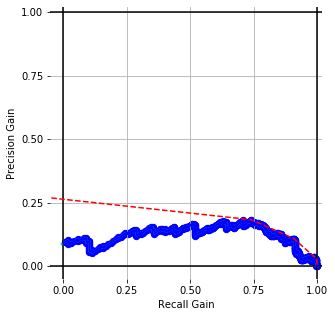

2020-07-21 17:18:56,168 : INFO : auprg:  0.121
2020-07-21 17:18:56,169 : INFO : compute_precision_recall_gain Complete: SimilarityMetric.SCM_sim


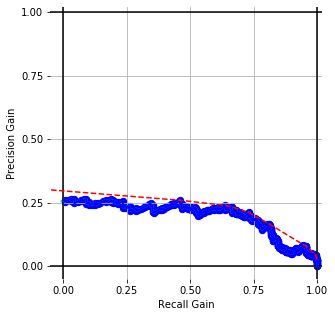

2020-07-21 17:18:56,308 : INFO : auprg:  0.198
2020-07-21 17:18:56,309 : INFO : compute_precision_recall_gain Complete: SimilarityMetric.WMD_sim


In [ ]:
supevisedEval.Compute_precision_recall_gain()

## Compute the average precision score¶
Precision is a metric that quantifies the number of correct positive predictions made.

Recall is a metric that quantifies the number of correct positive predictions made out of all positive predictions that could have been made.

2020-07-21 17:20:11,442 : INFO : Average precision-recall score: 0.37
2020-07-21 17:20:11,442 : INFO : Precision-Recall AUC: 0.37
2020-07-21 17:20:11,451 : INFO : Average precision-recall score: 0.39
2020-07-21 17:20:11,452 : INFO : Precision-Recall AUC: 0.39


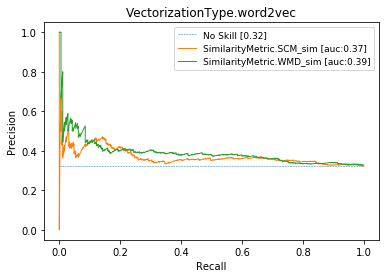

In [ ]:
supevisedEval.Compute_avg_precision_same_plot()

## Compute ROC Curve
An ROC curve (or receiver operating characteristic curve) is a plot that summarizes the performance of a binary classification model on the positive class [(see Blog)](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/).

Use ROC when both classes detection is equally important — When we want to give equal weight to both classes prediction ability we should look at the ROC curve [link](https://towardsdatascience.com/what-metrics-should-we-use-on-imbalanced-data-set-precision-recall-roc-e2e79252aeba).

2020-07-21 17:20:48,159 : INFO : ROC AUC 0.56
2020-07-21 17:20:48,164 : INFO : ROC AUC 0.58


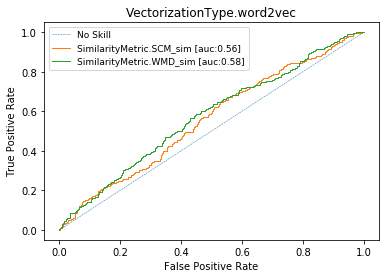

In [ ]:
supevisedEval.Compute_roc_curve()

## Compute distribution of similarities word2vec

In [ ]:
#Basic Statistics
filter_metrics = word2vec.df_ground_link
filter_metrics.describe()

,DistanceMetric.WMD,SimilarityMetric.WMD_sim,DistanceMetric.SCM,SimilarityMetric.SCM_sim,Linked?
count,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000
mean,1.081867,0.480801,0.821515,0.178485,0.322344
std,0.064566,0.014959,0.081902,0.081902,0.467588
min,0.906088,0.446098,0.561116,0.009846,0.000000
25%,1.036193,0.470165,0.759224,0.120910,0.000000
50%,1.082481,0.480196,0.821357,0.178643,0.000000
75%,1.126911,0.491113,0.879090,0.240776,1.000000
max,1.241660,0.524635,0.990154,0.438884,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe968f23668>,
      dtype=object)

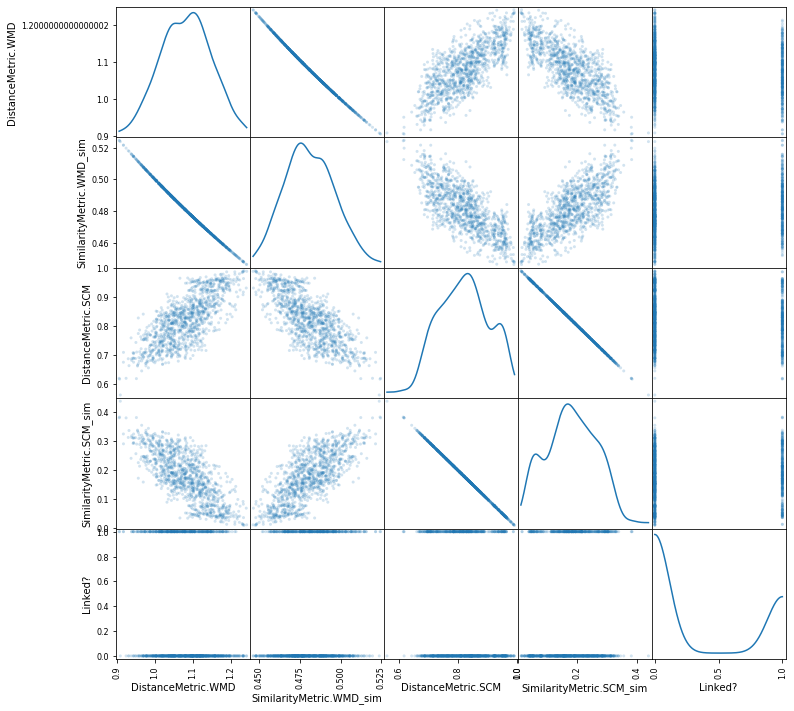

In [ ]:
scatter_matrix(filter_metrics, alpha=0.2, figsize=(12, 12), diagonal='kde')

Lag plots are used to check if a data set or time series is random. Random data should not exhibit any structure in the lag plot. Non-random structure implies that the underlying data are not random. The lag argument may be passed, and when lag=1 the plot is essentially data[:-1] vs. data[1:].

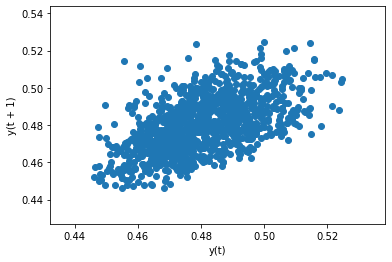

In [ ]:
lag_plot(filter_metrics[[SimilarityMetric.WMD_sim]])

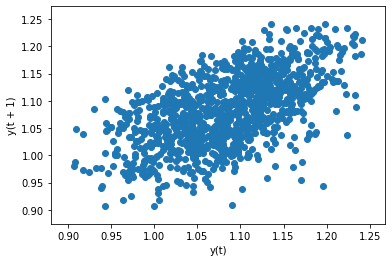

In [ ]:
lag_plot(filter_metrics[DistanceMetric.WMD])

In [ ]:
# calculate model precision-recall curve
sim = np.array(filter_metrics[SimilarityMetric.SCM_sim]) #SimilarityMetric.SCM_sim #SimilarityMetric.WMD_sim

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe96866dc18>,
      dtype=object)

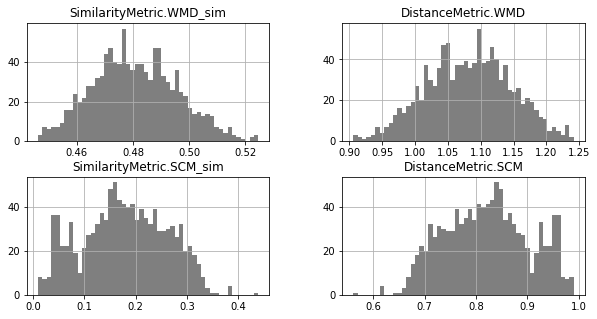

In [ ]:
filter_metrics.hist(column=[SimilarityMetric.WMD_sim,DistanceMetric.WMD,SimilarityMetric.SCM_sim,
                            DistanceMetric.SCM],color='k',bins=50,figsize=[10,5],alpha=0.5)

SimilarityMetric.WMD_sim    0.015274
DistanceMetric.WMD          0.064871
SimilarityMetric.SCM_sim    0.097195
DistanceMetric.SCM          0.097195
dtype: float64


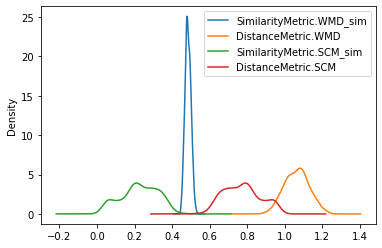

In [ ]:
errors = filter_metrics[[SimilarityMetric.WMD_sim,DistanceMetric.WMD,SimilarityMetric.SCM_sim,
                            DistanceMetric.SCM]].std()
print(errors)
filter_metrics[[SimilarityMetric.WMD_sim,DistanceMetric.WMD,SimilarityMetric.SCM_sim,
                            DistanceMetric.SCM]].plot.kde()

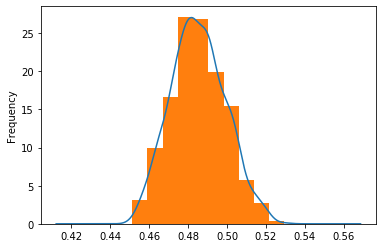

In [ ]:
filter_metrics[SimilarityMetric.WMD_sim].plot.kde()
filter_metrics[SimilarityMetric.WMD_sim].plot.hist(density=True) # Histogram will now be normalized

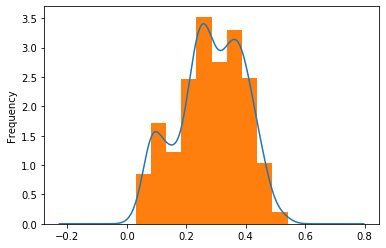

In [ ]:
filter_metrics[SimilarityMetric.SCM_sim].plot.kde()
filter_metrics[SimilarityMetric.SCM_sim].plot.hist(density=True) # Histogram will now be normalized

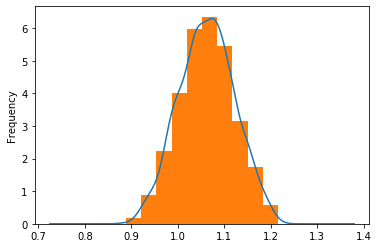

In [ ]:
filter_metrics[DistanceMetric.WMD].plot.kde()
filter_metrics[DistanceMetric.WMD].plot.hist(density=True)

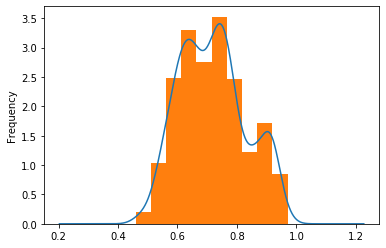

In [ ]:
filter_metrics[DistanceMetric.SCM].plot.kde()
filter_metrics[DistanceMetric.SCM].plot.hist(density=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe9706b1ba8>,
      dtype=object)

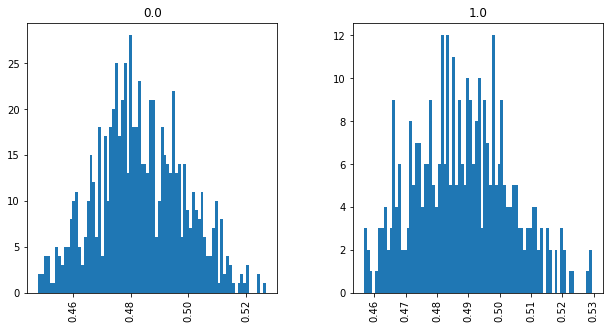

In [ ]:
filter_metrics.hist(by='Linked?',column=SimilarityMetric.WMD_sim ,figsize=[10, 5],bins=80)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe970245550>,
      dtype=object)

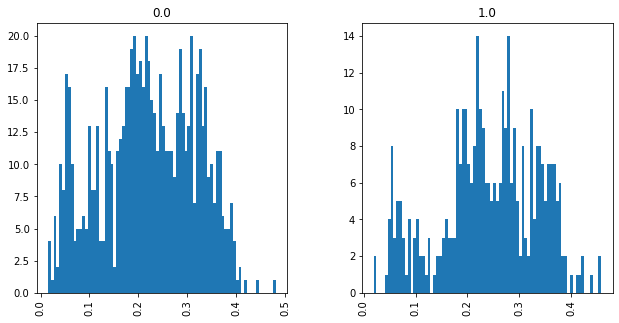

In [ ]:
filter_metrics.hist(by='Linked?',column=SimilarityMetric.SCM_sim ,figsize=[10, 5],bins=80)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe9701121d0>,
      dtype=object)

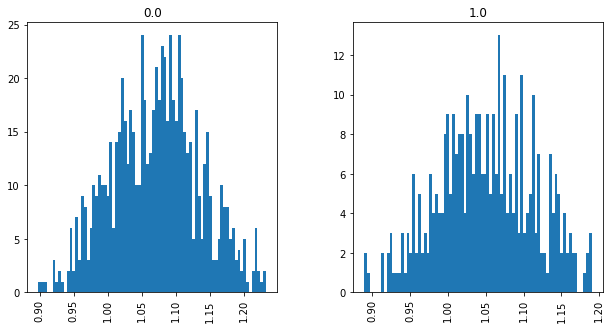

In [ ]:
filter_metrics.hist(by='Linked?',column=DistanceMetric.WMD,figsize=[10, 5],bins=80)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe9702681d0>,
      dtype=object)

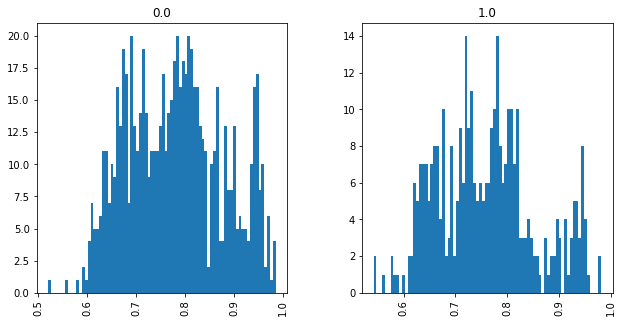

In [ ]:
filter_metrics.hist(by='Linked?',column=DistanceMetric.SCM,figsize=[10, 5],bins=80)

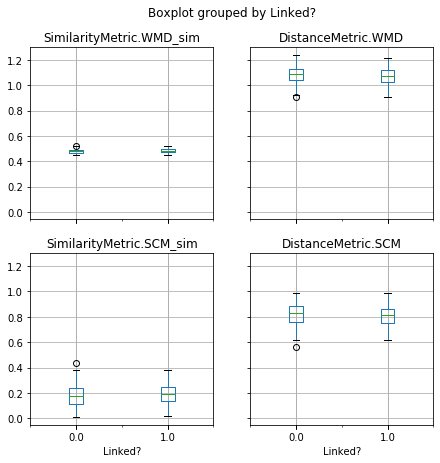

In [ ]:
boxplot = filter_metrics.boxplot(by='Linked?',column=[SimilarityMetric.WMD_sim,DistanceMetric.WMD,SimilarityMetric.SCM_sim,
                            DistanceMetric.SCM],figsize=[7, 7])

# Artifacts Similarity with Doc2Vec

Try to reproduce the same empirical evaluation like here: [link](https://arxiv.org/pdf/1507.07998.pdf). Pay attention to:
- Accuracy vs. Dimensionality (we can replace accuracy for false positive rate or true positive rate)
- Visualize paragraph vectors using t-sne
- Computing Cosine Distance and Similarity. More about similarity [link](https://www.kdnuggets.com/2017/08/comparing-distance-measurements-python-scipy.html)

In [ ]:
#path_to_trained_model": 'test_data/models/pv/conv/[doc2vec-Py-Java-PVDBOW-500-20E-1592609630.689167].model',
#"path_to_trained_model": 'test_data/models/pv/conv/[doc2vec-Py-Java-Wiki-PVDBOW-500-20E[15]-1592941134.367976].model',
path_to_trained_model = 'test_data/models/[doc2vec-Py-Java-PVDBOW-500-20E-8k-1594572857.17191].model'

In [ ]:
def doc2vec_params():
    return {
        "vectorizationType": VectorizationType.doc2vec,
        "linkType": LinkType.req2tc,
        "system": 'libest',
        "path_to_trained_model": path_to_trained_model,
        "source_path": '/tf/main/benchmarking/traceability/testbeds/nltk/[libest-pre-req].csv',
        "target_path": '/tf/main/benchmarking/traceability/testbeds/nltk/[libest-pre-tc].csv',
        "system_path": '/tf/main/benchmarking/traceability/testbeds/nltk/[libest-pre-all].csv',
        "saving_path": 'test_data/',
        "names": ['Source','Target','Linked?']
    }

In [ ]:
doc2vec_params = doc2vec_params()
doc2vec_params

{'vectorizationType': <VectorizationType.doc2vec: 2>,
 'linkType': <LinkType.req2tc: 1>,
 'system': 'libest',
 'path_to_trained_model': 'test_data/models/[doc2vec-Py-Java-PVDBOW-500-20E-8k-1594572857.17191].model',
 'source_path': '/tf/main/benchmarking/traceability/testbeds/nltk/[libest-pre-req].csv',
 'target_path': '/tf/main/benchmarking/traceability/testbeds/nltk/[libest-pre-tc].csv',
 'system_path': '/tf/main/benchmarking/traceability/testbeds/nltk/[libest-pre-all].csv',
 'saving_path': 'test_data/',
 'names': ['Source', 'Target', 'Linked?']}

In [ ]:
#Export
class Doc2VecSeqVect(BasicSequenceVectorization):
    
    def __init__(self, params):
        super().__init__(params)
        self.new_model = gensim.models.Doc2Vec.load( params['path_to_trained_model'] )
        self.new_model.init_sims(replace=True)  # Normalizes the vectors in the word2vec class.
        self.df_inferred_src = None
        self.df_inferred_trg = None
        
        self.dict_distance_dispatcher = {
            DistanceMetric.COS: self.cos_scipy,
            SimilarityMetric.Pearson: self.pearson_abs_scipy,
            DistanceMetric.EUC: self.euclidean_scipy,
            DistanceMetric.MAN: self.manhattan_scipy
        }
    
    def distance(self, metric_list, link):
        '''Iterate on the metrics'''
        ν_inferredSource = list(self.df_inferred_src[self.df_inferred_src['ids'].str.contains(link[0])]['inf-doc2vec'])
        w_inferredTarget = list(self.df_inferred_trg[self.df_inferred_trg['ids'].str.contains(link[1])]['inf-doc2vec'])
        
        dist = [ self.dict_distance_dispatcher[metric](ν_inferredSource,w_inferredTarget) for metric in metric_list]
        logging.info("Computed distances or similarities "+ str(link) + str(dist))    
        return functools.reduce(lambda a,b : a+b, dist) #Always return a list
    
    def computeDistanceMetric(self, links, metric_list):
        '''It is computed the cosine similarity'''
        
        metric_labels = [ self.dict_labels[metric] for metric in metric_list] #tracking of the labels
        distSim = [[link[0], link[1], self.distance( metric_list, link )] for link in links] #Return the link with metrics
        distSim = [[elem[0], elem[1]] + elem[2] for elem in distSim] #Return the link with metrics
        
        return distSim, functools.reduce(lambda a,b : a+b, metric_labels)

    
    def InferDoc2Vec(self, steps=200):
        '''Activate Inference on Target and Source Corpus'''
        self.df_inferred_src = self.df_source.copy()
        self.df_inferred_trg = self.df_target.copy()
        
        self.df_inferred_src['inf-doc2vec'] =  [self.new_model.infer_vector(artifact.split(),steps=steps) for artifact in self.df_inferred_src['text'].values]
        self.df_inferred_trg['inf-doc2vec'] =  [self.new_model.infer_vector(artifact.split(),steps=steps) for artifact in self.df_inferred_trg['text'].values]
        
        logging.info("Infer Doc2Vec on Source and Target Complete")
    

### Testing Doc2Vec SequenceVectorization

In [ ]:
doc2vec = Doc2VecSeqVect(params = doc2vec_params)

2020-07-13 15:15:01,838 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-13 15:15:01,899 : INFO : built Dictionary(6957 unique tokens: ['");', '"../../', '("\\', '();', ')))']...) from 87 documents (total 88944 corpus positions)
2020-07-13 15:15:01,899 : INFO : loading Doc2Vec object from test_data/models/[doc2vec-Py-Java-PVDBOW-500-20E-8k-1594572857.17191].model
2020-07-13 15:15:01,993 : INFO : loading vocabulary recursively from test_data/models/[doc2vec-Py-Java-PVDBOW-500-20E-8k-1594572857.17191].model.vocabulary.* with mmap=None
2020-07-13 15:15:01,994 : INFO : loading trainables recursively from test_data/models/[doc2vec-Py-Java-PVDBOW-500-20E-8k-1594572857.17191].model.trainables.* with mmap=None
2020-07-13 15:15:01,995 : INFO : loading syn1neg from test_data/models/[doc2vec-Py-Java-PVDBOW-500-20E-8k-1594572857.17191].model.trainables.syn1neg.npy with mmap=None
2020-07-13 15:15:02,319 : INFO : loading wv recursively from test_data/models/[doc2vec-Py-Java-PVD

In [ ]:
#[step1]Apply Doc2Vec Inference
doc2vec.InferDoc2Vec(steps=200)

2020-07-13 15:15:15,473 : INFO : Infer Doc2Vec on Source and Target Complete


In [ ]:
doc2vec.df_inferred_src.head(2)

,ids,text,inf-doc2vec
0,test_data/LibEST_semeru_format/requirements/RQ...,requir http uri control est server must suppor...,"[4.477832, 2.3790405, 0.5137581, 0.23571448, 3..."
1,test_data/LibEST_semeru_format/requirements/RQ...,requir server side key generat respons request...,"[0.4347369, 0.57583386, 0.9252513, 2.3536224, ..."


In [ ]:
#test_inferDoc2Vec_trg = inferDoc2Vec(df_target)
#test_inferDoc2Vec_trg.head()
doc2vec.df_inferred_trg.head(2)

,ids,text,inf-doc2vec
0,test_data/LibEST_semeru_format/test/us903.c,unit test user stori server simpl enrol august...,"[-2.1241925, -7.8275003, -2.9391506, -3.689754..."
1,test_data/LibEST_semeru_format/test/us3496.c,unit test uri path segment extens support marc...,"[-0.0029585396, -1.4706498, -2.2038684, -3.389..."


In [ ]:
pearsonr(doc2vec.df_inferred_trg['inf-doc2vec'][0], doc2vec.df_inferred_trg['inf-doc2vec'][0])

(1.0, 0.0)

In [ ]:
#[step 2]NonGroundTruth Computation
metric_l = [DistanceMetric.EUC,DistanceMetric.COS,DistanceMetric.MAN]# , SimilarityMetric.Pearson]
doc2vec.ComputeDistanceArtifacts( sampling=False, samples = 50, metric_list = metric_l )
doc2vec.df_nonground_link.head()

2020-07-13 15:15:18,434 : INFO : Computed distances or similarities ('RQ17-pre.txt', 'us903.c')[[44.104679107666016, 0.02217064880592487], [0.4672650098800659, 0.5327349901199341], [795.8113, 0.001255002314829709]]
2020-07-13 15:15:18,439 : INFO : Computed distances or similarities ('RQ17-pre.txt', 'us3496.c')[[43.14446258544922, 0.022652897813951807], [0.38366782665252686, 0.6163321733474731], [745.9744, 0.0013387339175640926]]
2020-07-13 15:15:18,444 : INFO : Computed distances or similarities ('RQ17-pre.txt', 'us899.c')[[47.40628433227539, 0.020658474695882403], [0.38994747400283813, 0.6100525259971619], [850.8949, 0.0011738537265342098]]
2020-07-13 15:15:18,447 : INFO : Computed distances or similarities ('RQ17-pre.txt', 'us4020.c')[[39.961090087890625, 0.024413412774276513], [0.37390029430389404, 0.626099705696106], [716.2025, 0.0013943063215418115]]
2020-07-13 15:15:18,449 : INFO : Computed distances or similarities ('RQ17-pre.txt', 'us897.c')[[43.58040237426758, 0.02243138120658

2020-07-13 15:15:18,598 : INFO : Computed distances or similarities ('RQ46-pre.txt', 'us1159.c')[[51.75005340576172, 0.01895732677856916], [0.6132848560810089, 0.3867151439189911], [911.1129, 0.0010963554879136576]]
2020-07-13 15:15:18,601 : INFO : Computed distances or similarities ('RQ46-pre.txt', 'us2174.c')[[50.5986213684082, 0.01938036275930931], [0.5362288653850555, 0.46377113461494446], [891.9458, 0.0011198887985419573]]
2020-07-13 15:15:18,607 : INFO : Computed distances or similarities ('RQ46-pre.txt', 'us893.c')[[47.971431732177734, 0.020420068693701852], [0.5751924216747284, 0.4248075783252716], [860.7991, 0.0011603632820943424]]
2020-07-13 15:15:18,610 : INFO : Computed distances or similarities ('RQ46-pre.txt', 'us895.c')[[48.9161491394043, 0.020033596686459737], [0.6266917288303375, 0.3733082711696625], [860.83, 0.0011603216181500817]]
2020-07-13 15:15:18,620 : INFO : Computed distances or similarities ('RQ18-pre.txt', 'us903.c')[[44.372562408447266, 0.02203975149117486],

2020-07-13 15:15:18,753 : INFO : Computed distances or similarities ('RQ48-pre.txt', 'us748.c')[[48.578548431396484, 0.02017001367806752], [0.5430891811847687, 0.4569108188152313], [881.11017, 0.0011336452472248213]]
2020-07-13 15:15:18,757 : INFO : Computed distances or similarities ('RQ48-pre.txt', 'us3612.c')[[41.70309829711914, 0.023417504581101145], [0.5248388946056366, 0.4751611053943634], [747.0024, 0.0013368941413045865]]
2020-07-13 15:15:18,760 : INFO : Computed distances or similarities ('RQ48-pre.txt', 'us901.c')[[54.376495361328125, 0.018058203096369015], [0.5221579372882843, 0.4778420627117157], [970.57526, 0.0010292563478398965]]
2020-07-13 15:15:18,762 : INFO : Computed distances or similarities ('RQ48-pre.txt', 'us1864.c')[[46.57534408569336, 0.02101929096295733], [0.5101349949836731, 0.4898650050163269], [823.2773, 0.0012131839867118442]]
2020-07-13 15:15:18,765 : INFO : Computed distances or similarities ('RQ48-pre.txt', 'us1159.c')[[48.69963073730469, 0.0201208738408

2020-07-13 15:15:18,874 : INFO : Computed distances or similarities ('RQ29-pre.txt', 'us1005.c')[[45.40437316894531, 0.02154969309377977], [0.5443133115768433, 0.45568668842315674], [821.8539, 0.0012152825939993346]]
2020-07-13 15:15:18,877 : INFO : Computed distances or similarities ('RQ29-pre.txt', 'us898.c')[[47.34998321533203, 0.02068253044776435], [0.6254967153072357, 0.3745032846927643], [840.8329, 0.001187884218990052]]
2020-07-13 15:15:18,880 : INFO : Computed distances or similarities ('RQ29-pre.txt', 'us3512.c')[[65.4877700805664, 0.015040360035962286], [0.6534695625305176, 0.3465304374694824], [1160.9978, 0.0008605868252477181]]
2020-07-13 15:15:18,882 : INFO : Computed distances or similarities ('RQ29-pre.txt', 'us1883.c')[[63.585636138916016, 0.015483318889189525], [0.7335700690746307, 0.26642993092536926], [1131.099, 0.0008833149758657257]]
2020-07-13 15:15:18,886 : INFO : Computed distances or similarities ('RQ29-pre.txt', 'us748.c')[[48.255638122558594, 0.02030224433417

2020-07-13 15:15:19,008 : INFO : Computed distances or similarities ('RQ36-pre.txt', 'us1060.c')[[37.60939407348633, 0.025900432368782384], [0.40515273809432983, 0.5948472619056702], [672.13, 0.0014855971249923608]]
2020-07-13 15:15:19,014 : INFO : Computed distances or similarities ('RQ36-pre.txt', 'us900.c')[[42.38471221923828, 0.023049593943291515], [0.4374401569366455, 0.5625598430633545], [746.80096, 0.001337254226279184]]
2020-07-13 15:15:19,016 : INFO : Computed distances or similarities ('RQ36-pre.txt', 'us896.c')[[35.005619049072266, 0.02777344276839385], [0.44993919134140015, 0.5500608086585999], [619.04126, 0.0016127958974504358]]
2020-07-13 15:15:19,021 : INFO : Computed distances or similarities ('RQ36-pre.txt', 'us894.c')[[50.0914306640625, 0.019572753923749405], [0.5059525370597839, 0.49404746294021606], [877.4912, 0.0011383153155656838]]
2020-07-13 15:15:19,024 : INFO : Computed distances or similarities ('RQ36-pre.txt', 'us1005.c')[[42.55540466308594, 0.022959263212804

2020-07-13 15:15:19,154 : INFO : Computed distances or similarities ('RQ15-pre.txt', 'us3496.c')[[45.15254592895508, 0.021667277067214233], [0.4218469262123108, 0.5781530737876892], [810.4939, 0.0012322951587587876]]
2020-07-13 15:15:19,159 : INFO : Computed distances or similarities ('RQ15-pre.txt', 'us899.c')[[49.33351135253906, 0.019867479401465507], [0.41455191373825073, 0.5854480862617493], [873.6051, 0.0011433731601804106]]
2020-07-13 15:15:19,164 : INFO : Computed distances or similarities ('RQ15-pre.txt', 'us4020.c')[[43.633846282958984, 0.02240452220183847], [0.4748319387435913, 0.5251680612564087], [795.8939, 0.0012548721652595564]]
2020-07-13 15:15:19,166 : INFO : Computed distances or similarities ('RQ15-pre.txt', 'us897.c')[[47.92394256591797, 0.020439889909784844], [0.5032338500022888, 0.4967661499977112], [839.8744, 0.0011892382647283282]]
2020-07-13 15:15:19,171 : INFO : Computed distances or similarities ('RQ15-pre.txt', 'us1060.c')[[38.82704544067383, 0.02510856602430

2020-07-13 15:15:19,287 : INFO : Computed distances or similarities ('RQ35-pre.txt', 'us2174.c')[[45.847373962402344, 0.021345913664286845], [0.41586750745773315, 0.5841324925422668], [824.1943, 0.0012118358432847143]]
2020-07-13 15:15:19,296 : INFO : Computed distances or similarities ('RQ35-pre.txt', 'us893.c')[[44.9688720703125, 0.02175385113801427], [0.5362891852855682, 0.46371081471443176], [810.79144, 0.0012318434849020604]]
2020-07-13 15:15:19,299 : INFO : Computed distances or similarities ('RQ35-pre.txt', 'us895.c')[[38.54386520385742, 0.025288372667789997], [0.3710975646972656, 0.6289024353027344], [688.0052, 0.0014513678814520163]]
2020-07-13 15:15:19,301 : INFO : Computed distances or similarities ('RQ51-pre.txt', 'us903.c')[[47.850406646728516, 0.020470658662714927], [0.48357176780700684, 0.5164282321929932], [853.9086, 0.0011697156450110064]]
2020-07-13 15:15:19,304 : INFO : Computed distances or similarities ('RQ51-pre.txt', 'us3496.c')[[49.37089920043945, 0.019852732745

2020-07-13 15:15:19,419 : INFO : Computed distances or similarities ('RQ26-pre.txt', 'us3612.c')[[37.92119598388672, 0.02569294120391361], [0.4121825695037842, 0.5878174304962158], [679.224, 0.0014701039678630104]]
2020-07-13 15:15:19,422 : INFO : Computed distances or similarities ('RQ26-pre.txt', 'us901.c')[[50.15414810180664, 0.019548756789181724], [0.41621774435043335, 0.5837822556495667], [892.35114, 0.0011193806785903756]]
2020-07-13 15:15:19,432 : INFO : Computed distances or similarities ('RQ26-pre.txt', 'us1864.c')[[42.71527099609375, 0.02287530140415592], [0.4124743342399597, 0.5875256657600403], [761.17206, 0.0013120397020138736]]
2020-07-13 15:15:19,438 : INFO : Computed distances or similarities ('RQ26-pre.txt', 'us1159.c')[[45.042327880859375, 0.021719145100300586], [0.4049810767173767, 0.5950189232826233], [802.65607, 0.001244313383788884]]
2020-07-13 15:15:19,443 : INFO : Computed distances or similarities ('RQ26-pre.txt', 'us2174.c')[[48.15876007080078, 0.0203422543318

2020-07-13 15:15:19,591 : INFO : Computed distances or similarities ('RQ10-pre.txt', 'us898.c')[[47.6529541015625, 0.02055373652980066], [0.47760820388793945, 0.5223917961120605], [862.70355, 0.0011578046627219053]]
2020-07-13 15:15:19,593 : INFO : Computed distances or similarities ('RQ10-pre.txt', 'us3512.c')[[66.28762817382812, 0.014861573028204244], [0.5110481381416321, 0.4889518618583679], [1182.0776, 0.0008452530662091515]]
2020-07-13 15:15:19,596 : INFO : Computed distances or similarities ('RQ10-pre.txt', 'us1883.c')[[63.001197814941406, 0.015624707570184646], [0.5482959747314453, 0.4517040252685547], [1124.0271, 0.0008888674773676242]]
2020-07-13 15:15:19,599 : INFO : Computed distances or similarities ('RQ10-pre.txt', 'us748.c')[[49.38692092895508, 0.019846420094015813], [0.49376535415649414, 0.5062346458435059], [890.5181, 0.0011216821837038008]]
2020-07-13 15:15:19,601 : INFO : Computed distances or similarities ('RQ10-pre.txt', 'us3612.c')[[42.246829986572266, 0.0231230820

2020-07-13 15:15:19,716 : INFO : Computed distances or similarities ('RQ25-pre.txt', 'us900.c')[[44.33628845214844, 0.022057385686864956], [0.4916069507598877, 0.5083930492401123], [806.88666, 0.0012377973945362094]]
2020-07-13 15:15:19,724 : INFO : Computed distances or similarities ('RQ25-pre.txt', 'us896.c')[[37.41788864135742, 0.026029540804162914], [0.49361681938171387, 0.5063831806182861], [680.3454, 0.0014676843830014844]]
2020-07-13 15:15:19,729 : INFO : Computed distances or similarities ('RQ25-pre.txt', 'us894.c')[[49.243892669677734, 0.019902916491251515], [0.48247796297073364, 0.5175220370292664], [874.44916, 0.0011422707888717]]
2020-07-13 15:15:19,735 : INFO : Computed distances or similarities ('RQ25-pre.txt', 'us1005.c')[[39.363868713378906, 0.024774632161771514], [0.36885201930999756, 0.6311479806900024], [705.8093, 0.0014148087227655365]]
2020-07-13 15:15:19,740 : INFO : Computed distances or similarities ('RQ25-pre.txt', 'us898.c')[[44.16895294189453, 0.0221391007510

2020-07-13 15:15:19,885 : INFO : Computed distances or similarities ('RQ4-pre.txt', 'us899.c')[[48.808189392089844, 0.020077019707100865], [0.4240027070045471, 0.5759972929954529], [850.8061, 0.0011739761081817838]]
2020-07-13 15:15:19,894 : INFO : Computed distances or similarities ('RQ4-pre.txt', 'us4020.c')[[38.97543716430664, 0.02501536120517732], [0.3507682681083679, 0.6492317318916321], [723.34937, 0.0013805492873959152]]
2020-07-13 15:15:19,899 : INFO : Computed distances or similarities ('RQ4-pre.txt', 'us897.c')[[40.755706787109375, 0.02394882225556568], [0.3203652501106262, 0.6796347498893738], [724.5299, 0.0013783029342272562]]
2020-07-13 15:15:19,902 : INFO : Computed distances or similarities ('RQ4-pre.txt', 'us1060.c')[[39.34248733520508, 0.02478776263077227], [0.44268643856048584, 0.5573135614395142], [711.0768, 0.001404342937391025]]
2020-07-13 15:15:19,907 : INFO : Computed distances or similarities ('RQ4-pre.txt', 'us900.c')[[41.355838775634766, 0.023609495854801744],

2020-07-13 15:15:20,038 : INFO : Computed distances or similarities ('RQ27-pre.txt', 'us893.c')[[43.842403411865234, 0.022300321211940248], [0.4394060969352722, 0.5605939030647278], [796.80493, 0.0012534392309954468]]
2020-07-13 15:15:20,040 : INFO : Computed distances or similarities ('RQ27-pre.txt', 'us895.c')[[40.71944046020508, 0.023969640747072578], [0.33628708124160767, 0.6637129187583923], [743.33905, 0.0013434737833604245]]
2020-07-13 15:15:20,045 : INFO : Computed distances or similarities ('RQ41-pre.txt', 'us903.c')[[49.55862808227539, 0.01977901770539884], [0.6567015051841736, 0.3432984948158264], [895.7979, 0.0011150784206259018]]
2020-07-13 15:15:20,048 : INFO : Computed distances or similarities ('RQ41-pre.txt', 'us3496.c')[[52.5023193359375, 0.018690778501041547], [0.6475266814231873, 0.35247331857681274], [928.77875, 0.001075524690821115]]
2020-07-13 15:15:20,053 : INFO : Computed distances or similarities ('RQ41-pre.txt', 'us899.c')[[57.077117919921875, 0.0172184852798

2020-07-13 15:15:20,177 : INFO : Computed distances or similarities ('RQ11-pre.txt', 'us901.c')[[53.69725799560547, 0.01828245211268804], [0.49997395277023315, 0.5000260472297668], [955.64624, 0.0010453184865442042]]
2020-07-13 15:15:20,181 : INFO : Computed distances or similarities ('RQ11-pre.txt', 'us1864.c')[[45.07966995239258, 0.02170154432601524], [0.4286511540412903, 0.5713488459587097], [798.5844, 0.0012506496943488175]]
2020-07-13 15:15:20,184 : INFO : Computed distances or similarities ('RQ11-pre.txt', 'us1159.c')[[48.74446487426758, 0.02010273911936868], [0.504805326461792, 0.495194673538208], [884.20667, 0.0011296797002266943]]
2020-07-13 15:15:20,190 : INFO : Computed distances or similarities ('RQ11-pre.txt', 'us2174.c')[[50.649051666259766, 0.01936143971164643], [0.4784727096557617, 0.5215272903442383], [905.8038, 0.0011027744159297058]]
2020-07-13 15:15:20,192 : INFO : Computed distances or similarities ('RQ11-pre.txt', 'us893.c')[[46.827674865722656, 0.0209083967139846

2020-07-13 15:15:20,356 : INFO : Computed distances or similarities ('RQ32-pre.txt', 'us3512.c')[[60.2693977355957, 0.016321361674149926], [0.4632112979888916, 0.5367887020111084], [1069.2864, 0.0009343293734587044]]
2020-07-13 15:15:20,361 : INFO : Computed distances or similarities ('RQ32-pre.txt', 'us1883.c')[[56.51464080810547, 0.017386877253331837], [0.449405312538147, 0.550594687461853], [1005.9237, 0.0009931239020264844]]
2020-07-13 15:15:20,363 : INFO : Computed distances or similarities ('RQ32-pre.txt', 'us748.c')[[42.6300048828125, 0.02292000660293159], [0.39070332050323486, 0.6092966794967651], [757.2549, 0.0013188177520081705]]
2020-07-13 15:15:20,368 : INFO : Computed distances or similarities ('RQ32-pre.txt', 'us3612.c')[[39.23383331298828, 0.024854703558091745], [0.4821392297744751, 0.5178607702255249], [697.67004, 0.0014312907912197158]]
2020-07-13 15:15:20,371 : INFO : Computed distances or similarities ('RQ32-pre.txt', 'us901.c')[[47.91719055175781, 0.0204427112170706

2020-07-13 15:15:20,509 : INFO : Computed distances or similarities ('RQ14-pre.txt', 'us896.c')[[37.09309768676758, 0.0262514749580833], [0.5055538713932037, 0.49444612860679626], [642.6544, 0.001553628733938614]]
2020-07-13 15:15:20,512 : INFO : Computed distances or similarities ('RQ14-pre.txt', 'us894.c')[[51.993370056152344, 0.018870285074159075], [0.5682562589645386, 0.4317437410354614], [933.90967, 0.0010696220546875612]]
2020-07-13 15:15:20,516 : INFO : Computed distances or similarities ('RQ14-pre.txt', 'us1005.c')[[48.238250732421875, 0.020309413618984046], [0.6359542310237885, 0.36404576897621155], [857.91516, 0.001164259341610774]]
2020-07-13 15:15:20,519 : INFO : Computed distances or similarities ('RQ14-pre.txt', 'us898.c')[[47.707427978515625, 0.020530749446287543], [0.609104335308075, 0.39089566469192505], [854.666, 0.0011686802814876022]]
2020-07-13 15:15:20,524 : INFO : Computed distances or similarities ('RQ14-pre.txt', 'us3512.c')[[60.16168212890625, 0.01635010622978

2020-07-13 15:15:20,667 : INFO : Computed distances or similarities ('RQ55-pre.txt', 'us4020.c')[[47.7627067565918, 0.020507475210342355], [0.6377618312835693, 0.36223816871643066], [868.854, 0.001149618206629278]]
2020-07-13 15:15:20,670 : INFO : Computed distances or similarities ('RQ55-pre.txt', 'us897.c')[[51.259403228759766, 0.019135312273326398], [0.6271801292896271, 0.3728198707103729], [913.5444, 0.0010934406574525516]]
2020-07-13 15:15:20,675 : INFO : Computed distances or similarities ('RQ55-pre.txt', 'us1060.c')[[43.777099609375, 0.022332844438870927], [0.649742603302002, 0.35025739669799805], [787.8429, 0.0012676795413822629]]
2020-07-13 15:15:20,677 : INFO : Computed distances or similarities ('RQ55-pre.txt', 'us900.c')[[46.82487869262695, 0.020909619163428587], [0.594510942697525, 0.405489057302475], [847.07227, 0.001179144797599335]]
2020-07-13 15:15:20,683 : INFO : Computed distances or similarities ('RQ55-pre.txt', 'us896.c')[[39.09999084472656, 0.02493766155389303], [

2020-07-13 15:15:20,814 : INFO : Computed distances or similarities ('RQ39-pre.txt', 'us895.c')[[47.380157470703125, 0.02066963094540475], [0.6281534731388092, 0.3718465268611908], [852.2311, 0.0011720154416468077]]
2020-07-13 15:15:20,817 : INFO : Computed distances or similarities ('RQ37-pre.txt', 'us903.c')[[46.144813537597656, 0.021211240960843064], [0.5398991703987122, 0.46010082960128784], [839.6869, 0.0011895035028061218]]
2020-07-13 15:15:20,821 : INFO : Computed distances or similarities ('RQ37-pre.txt', 'us3496.c')[[48.26363754272461, 0.02029894765957417], [0.506372332572937, 0.493627667427063], [853.3278, 0.00117051087041243]]
2020-07-13 15:15:20,824 : INFO : Computed distances or similarities ('RQ37-pre.txt', 'us899.c')[[49.459129333496094, 0.019818019319968207], [0.3544623851776123, 0.6455376148223877], [886.46606, 0.001126803649237248]]
2020-07-13 15:15:20,829 : INFO : Computed distances or similarities ('RQ37-pre.txt', 'us4020.c')[[43.183406829833984, 0.02263293104244667

2020-07-13 15:15:20,976 : INFO : Computed distances or similarities ('RQ20-pre.txt', 'us1864.c')[[41.20563507080078, 0.02369351861007376], [0.39981991052627563, 0.6001800894737244], [737.2026, 0.0013546417107444734]]
2020-07-13 15:15:20,978 : INFO : Computed distances or similarities ('RQ20-pre.txt', 'us1159.c')[[43.48731994628906, 0.0224783151964949], [0.3976237177848816, 0.6023762822151184], [780.26416, 0.0012799768004204924]]
2020-07-13 15:15:20,984 : INFO : Computed distances or similarities ('RQ20-pre.txt', 'us2174.c')[[47.44416809082031, 0.0206423195899506], [0.4598231911659241, 0.5401768088340759], [858.0518, 0.0011640741315714965]]
2020-07-13 15:15:20,987 : INFO : Computed distances or similarities ('RQ20-pre.txt', 'us893.c')[[44.787864685058594, 0.02183984789153791], [0.5337391495704651, 0.4662608504295349], [800.9295, 0.001246992403347243]]
2020-07-13 15:15:20,990 : INFO : Computed distances or similarities ('RQ20-pre.txt', 'us895.c')[[39.54057693481445, 0.024666644522792776]

2020-07-13 15:15:21,145 : INFO : Computed distances or similarities ('RQ9-pre.txt', 'us748.c')[[48.71587371826172, 0.020114300025520386], [0.6163920164108276, 0.38360798358917236], [878.53253, 0.0011369676093999962]]
2020-07-13 15:15:21,151 : INFO : Computed distances or similarities ('RQ9-pre.txt', 'us3612.c')[[41.9573860168457, 0.023278883859642923], [0.5958274304866791, 0.4041725695133209], [759.0766, 0.001315656870842148]]
2020-07-13 15:15:21,153 : INFO : Computed distances or similarities ('RQ9-pre.txt', 'us901.c')[[55.00801467895508, 0.017854587521663186], [0.6395394206047058, 0.3604605793952942], [975.5351, 0.0010240287368064266]]
2020-07-13 15:15:21,159 : INFO : Computed distances or similarities ('RQ9-pre.txt', 'us1864.c')[[48.134281158447266, 0.020352388931369925], [0.6666862666606903, 0.3333137333393097], [854.1117, 0.0011694378718286385]]
2020-07-13 15:15:21,164 : INFO : Computed distances or similarities ('RQ9-pre.txt', 'us1159.c')[[48.90757369995117, 0.02003703898755107],

2020-07-13 15:15:21,301 : INFO : Computed distances or similarities ('RQ21-pre.txt', 'us1005.c')[[43.062740325927734, 0.022694911678281898], [0.4611474275588989, 0.5388525724411011], [780.07697, 0.0012802835628047307]]
2020-07-13 15:15:21,304 : INFO : Computed distances or similarities ('RQ21-pre.txt', 'us898.c')[[44.003726959228516, 0.022220381900946957], [0.48629283905029297, 0.513707160949707], [796.4869, 0.00125393912838832]]
2020-07-13 15:15:21,307 : INFO : Computed distances or similarities ('RQ21-pre.txt', 'us3512.c')[[61.663734436035156, 0.015958193506975926], [0.504319041967392, 0.49568095803260803], [1095.8025, 0.0009117411830331555]]
2020-07-13 15:15:21,310 : INFO : Computed distances or similarities ('RQ21-pre.txt', 'us1883.c')[[57.930118560791016, 0.016969251452776595], [0.49104905128479004, 0.50895094871521], [1039.502, 0.0009610746015388457]]
2020-07-13 15:15:21,312 : INFO : Computed distances or similarities ('RQ21-pre.txt', 'us748.c')[[45.82596206665039, 0.021355674413

2020-07-13 15:15:21,560 : INFO : Computed distances or similarities ('RQ53-pre.txt', 'us903.c')[[47.287662506103516, 0.02070922360082352], [0.5915136337280273, 0.40848636627197266], [852.19995, 0.0011720582011596394]]
2020-07-13 15:15:21,562 : INFO : Computed distances or similarities ('RQ53-pre.txt', 'us3496.c')[[49.8024787902832, 0.01968407888378994], [0.5742587149143219, 0.4257412850856781], [890.1948, 0.0011220891019835446]]
2020-07-13 15:15:21,566 : INFO : Computed distances or similarities ('RQ53-pre.txt', 'us899.c')[[55.31622314453125, 0.01775687260549375], [0.6180990636348724, 0.38190093636512756], [990.90204, 0.0010081640737803316]]
2020-07-13 15:15:21,569 : INFO : Computed distances or similarities ('RQ53-pre.txt', 'us4020.c')[[48.014530181884766, 0.020402113338415493], [0.6507778763771057, 0.3492221236228943], [868.9978, 0.0011494281903437367]]
2020-07-13 15:15:21,574 : INFO : Computed distances or similarities ('RQ53-pre.txt', 'us897.c')[[52.739688873291016, 0.0186082208692

2020-07-13 15:15:21,704 : INFO : Computed distances or similarities ('RQ7-pre.txt', 'us1159.c')[[50.979713439941406, 0.019238274584861336], [0.6549107730388641, 0.34508922696113586], [919.7133, 0.001086114407807455]]
2020-07-13 15:15:21,706 : INFO : Computed distances or similarities ('RQ7-pre.txt', 'us2174.c')[[52.62687301635742, 0.018647367331952717], [0.600623369216919, 0.39937663078308105], [944.6497, 0.0010574740093038865]]
2020-07-13 15:15:21,711 : INFO : Computed distances or similarities ('RQ7-pre.txt', 'us893.c')[[47.89467239379883, 0.02045212598922796], [0.6518014371395111, 0.3481985628604889], [868.8882, 0.0011495730357765316]]
2020-07-13 15:15:21,714 : INFO : Computed distances or similarities ('RQ7-pre.txt', 'us895.c')[[46.3938102722168, 0.021099801730569447], [0.6313689351081848, 0.3686310648918152], [827.6636, 0.0012067623473648917]]
2020-07-13 15:15:21,719 : INFO : Computed distances or similarities ('RQ50-pre.txt', 'us903.c')[[47.64487075805664, 0.02055715195490325], [

2020-07-13 15:15:21,849 : INFO : Computed distances or similarities ('RQ28-pre.txt', 'us748.c')[[46.931766510009766, 0.02086299072226279], [0.4706372618675232, 0.5293627381324768], [852.3635, 0.0011718335389859233]]
2020-07-13 15:15:21,856 : INFO : Computed distances or similarities ('RQ28-pre.txt', 'us3612.c')[[39.990474700927734, 0.024395911667189525], [0.4471338987350464, 0.5528661012649536], [719.89984, 0.001387155250561267]]
2020-07-13 15:15:21,858 : INFO : Computed distances or similarities ('RQ28-pre.txt', 'us901.c')[[52.119728088378906, 0.018825397568606374], [0.4170028567314148, 0.5829971432685852], [927.4679, 0.0010770431641613887]]
2020-07-13 15:15:21,861 : INFO : Computed distances or similarities ('RQ28-pre.txt', 'us1864.c')[[45.13142013549805, 0.021677199554290368], [0.45641642808914185, 0.5435835719108582], [804.2472, 0.0012418546869327083]]
2020-07-13 15:15:21,863 : INFO : Computed distances or similarities ('RQ28-pre.txt', 'us1159.c')[[46.795719146728516, 0.02092237584

2020-07-13 15:15:21,987 : INFO : Computed distances or similarities ('RQ23-pre.txt', 'us1005.c')[[48.32036209106445, 0.020275601346024456], [0.6806956827640533, 0.31930431723594666], [863.4178, 0.0011568480156321347]]
2020-07-13 15:15:21,990 : INFO : Computed distances or similarities ('RQ23-pre.txt', 'us898.c')[[47.31639099121094, 0.020696910085480233], [0.6225888729095459, 0.3774111270904541], [844.7672, 0.0011823584384843815]]
2020-07-13 15:15:21,995 : INFO : Computed distances or similarities ('RQ23-pre.txt', 'us3512.c')[[65.65729522705078, 0.015002108870360843], [0.6686905026435852, 0.3313094973564148], [1163.4193, 0.0008587971619018205]]
2020-07-13 15:15:21,998 : INFO : Computed distances or similarities ('RQ23-pre.txt', 'us1883.c')[[61.93207931518555, 0.015890147137704688], [0.6546916663646698, 0.3453083336353302], [1105.9309, 0.0009033987510776934]]
2020-07-13 15:15:22,003 : INFO : Computed distances or similarities ('RQ23-pre.txt', 'us748.c')[[50.22886276245117, 0.019520245933

2020-07-13 15:15:22,142 : INFO : Computed distances or similarities ('RQ31-pre.txt', 'us1060.c')[[44.64611053466797, 0.021907671612907863], [0.6053566336631775, 0.3946433663368225], [795.1408, 0.001256059216936315]]
2020-07-13 15:15:22,144 : INFO : Computed distances or similarities ('RQ31-pre.txt', 'us900.c')[[48.63176727294922, 0.020148385901725276], [0.5434189140796661, 0.45658108592033386], [884.83777, 0.0011288748747206579]]
2020-07-13 15:15:22,147 : INFO : Computed distances or similarities ('RQ31-pre.txt', 'us896.c')[[39.433631896972656, 0.024731886627153865], [0.5526152849197388, 0.44738471508026123], [694.4675, 0.0014378816520895096]]
2020-07-13 15:15:22,149 : INFO : Computed distances or similarities ('RQ31-pre.txt', 'us894.c')[[55.64173889160156, 0.017654825214913607], [0.6448898017406464, 0.35511019825935364], [1005.4584, 0.0009935830689175753]]
2020-07-13 15:15:22,152 : INFO : Computed distances or similarities ('RQ31-pre.txt', 'us1005.c')[[48.97856140136719, 0.02000857911

2020-07-13 15:15:22,297 : INFO : Computed distances or similarities ('RQ19-pre.txt', 'us3496.c')[[45.043277740478516, 0.021718697040564065], [0.40899038314819336, 0.5910096168518066], [789.8705, 0.001264429538074193]]
2020-07-13 15:15:22,300 : INFO : Computed distances or similarities ('RQ19-pre.txt', 'us899.c')[[50.83551025390625, 0.019291794275810015], [0.4558315873146057, 0.5441684126853943], [890.8872, 0.0011212180106592356]]
2020-07-13 15:15:22,303 : INFO : Computed distances or similarities ('RQ19-pre.txt', 'us4020.c')[[42.824073791503906, 0.022818508492788003], [0.44262707233428955, 0.5573729276657104], [764.8553, 0.0013057297099652663]]
2020-07-13 15:15:22,306 : INFO : Computed distances or similarities ('RQ19-pre.txt', 'us897.c')[[47.181697845458984, 0.020754768817144283], [0.47248250246047974, 0.5275174975395203], [825.2938, 0.0012102232545757505]]
2020-07-13 15:15:22,312 : INFO : Computed distances or similarities ('RQ19-pre.txt', 'us1060.c')[[39.83853530883789, 0.0244866764

2020-07-13 15:15:22,446 : INFO : Computed distances or similarities ('RQ1-pre.txt', 'us2174.c')[[44.97848892211914, 0.02174930110673829], [0.3981005549430847, 0.6018994450569153], [800.30505, 0.0012479641746534393]]
2020-07-13 15:15:22,452 : INFO : Computed distances or similarities ('RQ1-pre.txt', 'us893.c')[[42.4966926574707, 0.022990253715951127], [0.4561551809310913, 0.5438448190689087], [761.16003, 0.0013120604009055651]]
2020-07-13 15:15:22,456 : INFO : Computed distances or similarities ('RQ1-pre.txt', 'us895.c')[[38.99039077758789, 0.025006007207122302], [0.3876095414161682, 0.6123904585838318], [706.7018, 0.001413024560788603]]
2020-07-13 15:15:22,459 : INFO : Computed distances or similarities ('RQ38-pre.txt', 'us903.c')[[45.91328048706055, 0.02131592567430488], [0.5197494626045227, 0.4802505373954773], [830.67444, 0.0012023935734177082]]
2020-07-13 15:15:22,462 : INFO : Computed distances or similarities ('RQ38-pre.txt', 'us3496.c')[[45.33595657348633, 0.021581511939093218],

,Source,Target,DistanceMetric.EUC,SimilarityMetric.EUC_sim,DistanceMetric.COS,SimilarityMetric.COS_sim,DistanceMetric.MAN,SimilarityMetric.MAN_sim
0,RQ17-pre.txt,us903.c,44.104679,0.022171,0.467265,0.532735,795.811279,0.001255
1,RQ17-pre.txt,us3496.c,43.144463,0.022653,0.383668,0.616332,745.974426,0.001339
2,RQ17-pre.txt,us899.c,47.406284,0.020658,0.389947,0.610053,850.894897,0.001174
3,RQ17-pre.txt,us4020.c,39.961090,0.024413,0.373900,0.626100,716.202515,0.001394
4,RQ17-pre.txt,us897.c,43.580402,0.022431,0.386706,0.613294,761.245972,0.001312


In [ ]:
#[step 3]Saving Non-GroundTruth Links
doc2vec.SaveLinks()

2020-07-13 15:15:25,274 : INFO : Saving in...test_data/[libest-VectorizationType.doc2vec-LinkType.req2tc-False-1594653325.258415].csv


In [ ]:
#Loading Non-GroundTruth Links (change the timestamp with the assigned in the previous step)
df_nonglinks_doc2vec = LoadLinks(timestamp=1594653325.258415, params=doc2vec_params)
df_nonglinks_doc2vec.head()

2020-07-13 15:15:39,344 : INFO : Loading computed links from... test_data/[libest-VectorizationType.doc2vec-LinkType.req2tc-False-1594653325.258415].csv


,Source,Target,DistanceMetric.EUC,SimilarityMetric.EUC_sim,DistanceMetric.COS,SimilarityMetric.COS_sim,DistanceMetric.MAN,SimilarityMetric.MAN_sim
0,RQ17-pre.txt,us903.c,44.104679,0.022171,0.467265,0.532735,795.811279,0.001255
1,RQ17-pre.txt,us3496.c,43.144463,0.022653,0.383668,0.616332,745.974426,0.001339
2,RQ17-pre.txt,us899.c,47.406284,0.020658,0.389947,0.610053,850.894897,0.001174
3,RQ17-pre.txt,us4020.c,39.961090,0.024413,0.373900,0.626100,716.202515,0.001394
4,RQ17-pre.txt,us897.c,43.580402,0.022431,0.386706,0.613294,761.245972,0.001312


In [ ]:
#[step 4]GroundTruthMatching Testing
path_to_ground_truth = '/tf/main/benchmarking/traceability/testbeds/groundtruth/english/[libest-ground-req-to-tc].txt'
doc2vec.MatchWithGroundTruth(path_to_ground_truth)
doc2vec.df_ground_link

2020-07-13 15:15:46,173 : INFO : Groundtruth links computed


,Source,Target,DistanceMetric.EUC,SimilarityMetric.EUC_sim,DistanceMetric.COS,SimilarityMetric.COS_sim,DistanceMetric.MAN,SimilarityMetric.MAN_sim,Linked?
0,RQ17-pre.txt,us903.c,44.104679,0.022171,0.467265,0.532735,795.811279,0.001255,0.0
1,RQ17-pre.txt,us3496.c,43.144463,0.022653,0.383668,0.616332,745.974426,0.001339,0.0
2,RQ17-pre.txt,us899.c,47.406284,0.020658,0.389947,0.610053,850.894897,0.001174,0.0
3,RQ17-pre.txt,us4020.c,39.961090,0.024413,0.373900,0.626100,716.202515,0.001394,0.0
4,RQ17-pre.txt,us897.c,43.580402,0.022431,0.386706,0.613294,761.245972,0.001312,0.0
...,...,...,...,...,...,...,...,...,...
1087,RQ6-pre.txt,us1864.c,48.110874,0.020362,0.642231,0.357769,846.059814,0.001181,0.0
1088,RQ6-pre.txt,us1159.c,51.451035,0.019065,0.701942,0.298058,931.419617,0.001072,1.0
1089,RQ6-pre.txt,us2174.c,53.151653,0.018467,0.655729,0.344271,952.530884,0.001049,0.0
1090,RQ6-pre.txt,us893.c,46.669777,0.020978,0.562645,0.437355,841.773071,0.001187,1.0


In [ ]:
#[step 5]Saving GroundTruth Links
doc2vec.SaveLinks(grtruth = True)

2020-07-13 15:15:50,213 : INFO : Saving in...test_data/[libest-VectorizationType.doc2vec-LinkType.req2tc-True-1594653350.19946].csv


In [ ]:
#Loading Non-GroundTruth Links (change the timestamp with the assigned in the previous step)
df_glinks_doc2vec = LoadLinks(timestamp=1594653350.19946, params=doc2vec_params, grtruth = True)
df_glinks_doc2vec.head()

2020-07-13 15:16:04,268 : INFO : Loading computed links from... test_data/[libest-VectorizationType.doc2vec-LinkType.req2tc-True-1594653350.19946].csv


,Source,Target,DistanceMetric.EUC,SimilarityMetric.EUC_sim,DistanceMetric.COS,SimilarityMetric.COS_sim,DistanceMetric.MAN,SimilarityMetric.MAN_sim,Linked?
0,RQ17-pre.txt,us903.c,44.104679,0.022171,0.467265,0.532735,795.811279,0.001255,0.0
1,RQ17-pre.txt,us3496.c,43.144463,0.022653,0.383668,0.616332,745.974426,0.001339,0.0
2,RQ17-pre.txt,us899.c,47.406284,0.020658,0.389947,0.610053,850.894897,0.001174,0.0
3,RQ17-pre.txt,us4020.c,39.961090,0.024413,0.373900,0.626100,716.202515,0.001394,0.0
4,RQ17-pre.txt,us897.c,43.580402,0.022431,0.386706,0.613294,761.245972,0.001312,0.0


# Approach Evaluation and Interpretation (doc2vec)

In [ ]:
#supervisedEvalDoc2vec = SupervisedVectorEvaluation(doc2vec, similarity=SimilarityMetric.EUC_sim)
#supervisedEvalDoc2vec = SupervisedVectorEvaluation(doc2vec, similarity=SimilarityMetric.COS_sim)
supervisedEvalDoc2vec = SupervisedVectorEvaluation(doc2vec, similarity=SimilarityMetric.MAN_sim)

In [ ]:
supervisedEvalDoc2vec.y_test

array([0., 0., 0., ..., 0., 1., 1.])

In [ ]:
supervisedEvalDoc2vec.y_score

array([0.001255  , 0.00133873, 0.00117385, ..., 0.00104873, 0.00118656,
       0.00118146])

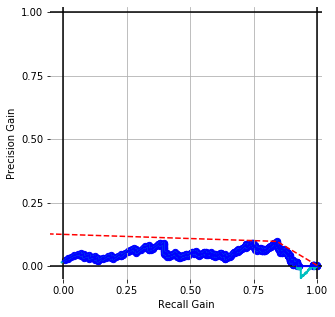

2020-07-13 15:19:42,710 : INFO : auprg:  0.046
2020-07-13 15:19:42,711 : INFO : compute_precision_recall_gain Complete


In [ ]:
supervisedEvalDoc2vec.Compute_precision_recall_gain()

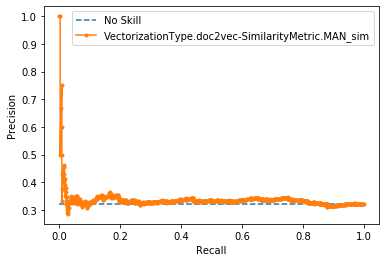

2020-07-13 15:20:09,414 : INFO : Average precision-recall score: 0.34
2020-07-13 15:20:09,415 : INFO : Precision-Recall AUC: 0.337


In [ ]:
supervisedEvalDoc2vec.Compute_avg_precision()

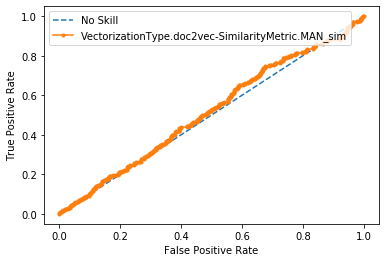

2020-07-13 15:20:34,277 : INFO : ROC AUC 0.518


In [ ]:
supervisedEvalDoc2vec.Compute_roc_curve()

## Compute distribution of similarities doc2vec

In [ ]:
#Basic Statistics
filter_doc2vec = doc2vec.df_ground_link
filter_doc2vec.describe()

,DistanceMetric.EUC,SimilarityMetric.EUC_sim,DistanceMetric.COS,SimilarityMetric.COS_sim,DistanceMetric.MAN,SimilarityMetric.MAN_sim,Linked?
count,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000
mean,47.733524,0.020839,0.524039,0.475961,853.416230,0.001189,0.322344
std,6.189149,0.002567,0.096515,0.096515,109.042188,0.000148,0.467588
min,31.985212,0.014488,0.295875,0.238356,568.586487,0.000822,0.000000
25%,43.779655,0.019465,0.447439,0.397129,785.647903,0.001108,0.000000
50%,47.310490,0.020699,0.511253,0.488747,845.838013,0.001181,0.000000
75%,50.374175,0.022332,0.602871,0.552561,901.169769,0.001271,1.000000
max,68.022263,0.030317,0.761644,0.704125,1215.307373,0.001756,1.000000


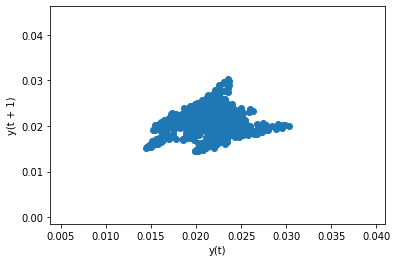

In [ ]:
lag_plot(filter_doc2vec[[SimilarityMetric.EUC_sim]])

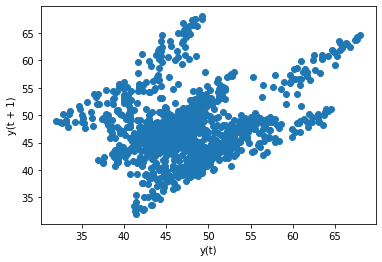

In [ ]:
lag_plot(filter_doc2vec[DistanceMetric.EUC])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe03a807160>,
      dtype=object)

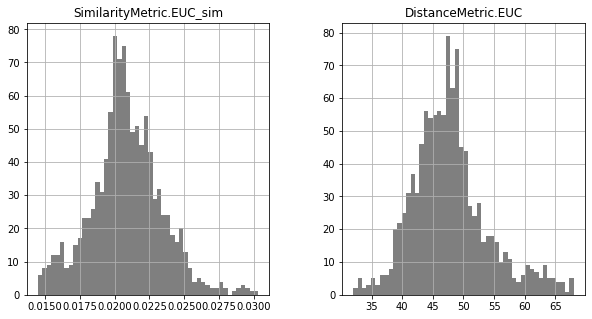

In [ ]:
filter_doc2vec.hist(column=[SimilarityMetric.EUC_sim,DistanceMetric.EUC],color='k',bins=50,figsize=[10,5],alpha=0.5)

SimilarityMetric.EUC_sim    0.007993
DistanceMetric.EUC          7.090463
dtype: float64


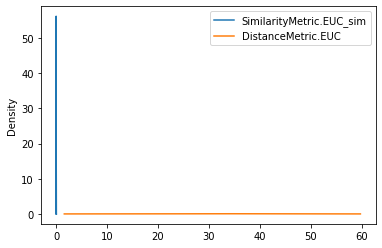

In [ ]:
#Separate distance from similarity analysis here
errors = filter_doc2vec[[SimilarityMetric.EUC_sim,DistanceMetric.EUC]].std()
print(errors)
filter_doc2vec[[SimilarityMetric.EUC_sim,DistanceMetric.EUC]].plot.kde()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f33c5833ba8>,
      dtype=object)

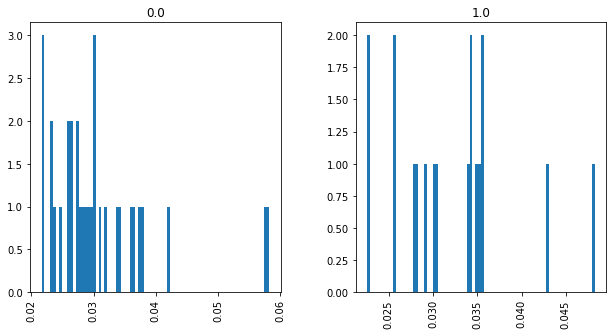

In [ ]:
filter_doc2vec.hist(by='Linked?',column=SimilarityMetric.EUC_sim,figsize=[10, 5],bins=80)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f33c37f8be0>,
      dtype=object)

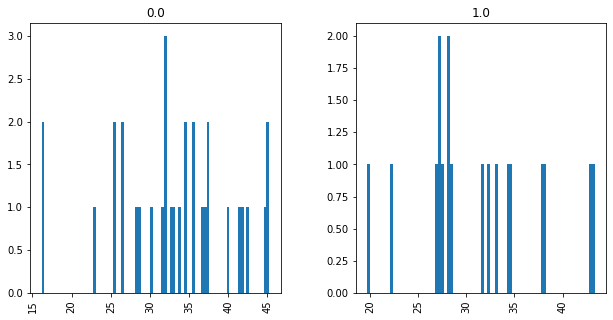

In [ ]:
filter_doc2vec.hist(by='Linked?',column=DistanceMetric.EUC,figsize=[10, 5],bins=80)

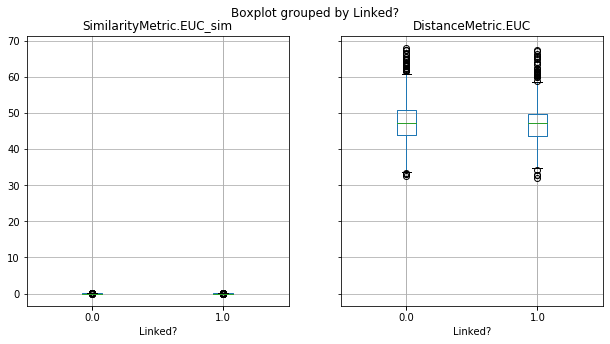

In [ ]:
#separate the distance from the similarity plot
boxplot = filter_doc2vec.boxplot(by='Linked?',column=[SimilarityMetric.EUC_sim,DistanceMetric.EUC],figsize=[10, 5])

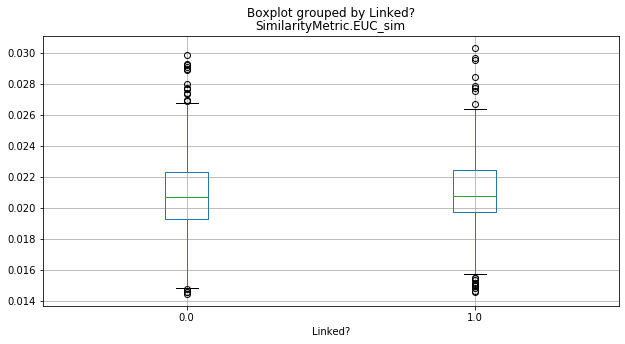

In [ ]:
boxplot = filter_doc2vec.boxplot(by='Linked?',column=[SimilarityMetric.EUC_sim],figsize=[10, 5])

## Combining Doc2vec and Word2vec
Please check this post for futher detatils [link](https://stats.stackexchange.com/questions/217614/intepreting-doc2vec-cosine-similarity-between-doc-vectors-and-word-vectors)

In [ ]:
! nbdev_build_docs #<-------- [Activate when stable]